In [ ]:
#ЭТА ЯЧЕЙКА НУЖНА, ЧТОБЫ ВСЕ ИМПОРТИРОВАТЬ!!!
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from jax import grad
import jax.numpy as jnp
import torch as tr
import time
from random import randint
plt.style.use('seaborn-darkgrid')

<ipython-input-1-3b360a1879a7>:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


### Часть 1. Решаем задачу безусловной оптимизации

Рассмотрим задачу минимизации эмпирического риска (да-да, machine learning):
\begin{equation}
\min_{w \in \mathbb{R}^d} \frac{1}{n} \sum\limits_{i=1}^n \ell (g(w, x_i), y_i) + \frac{\lambda}{2} \| w \|^2_2,
\end{equation}
где $\ell$ - функция потерь, $g$ - модель, $w$ - параметры модели, $\{x_i, y_i\}_{i=1}^n$ - выборка данных из векторов признаков $x_i$ и меток $y_i$, $\lambda > 0$ - параметр регуляризации.

Используем линейную модель $g(w, x) = w^T x$ и логистическую/сигмоидную функцию потерь: $\ell(z,y) = \ln (1 + \exp(-yz))$ (__Важно: $y$ должен принимать значения $-1$ или $1$__). Полученная задача называется задачей логистической регрессии.

__Задача 1. (всего 12 баллов)__ Проведем подготовительную работу.

__а). (8 баллов)__ Выпишите градиент и гессиан для данной задачи. Является ли задача выпуклой? А $\mu$ - сильно выпуклой? Если да, то как можно оценить $\mu$? Оцените константу Липшица градиента $L$.

$f = \displaystyle{\min_{w \in \mathbb{R}^d}} \frac{1}{n} \sum\limits_{i=1}^n \ln(1 + e^{-y_iw^Tx_i}) + \frac{\lambda}{2} \| w \|^2_2$ => $∇f = \displaystyle{-\min_{w \in \mathbb{R}^d}} \frac{1}{n} \sum\limits_{i=1}^n \frac{e^{-y_iw^Tx_i}}{1 + e^{-y_iw^Tx_i}} \cdot (y_ix_i) + \lambda w$.<br>

$∇^2 f = \displaystyle{-\min_{w \in \mathbb{R}^d}} \frac{1}{n} \sum\limits_{i=1}^n \frac{e^{-y_iw^Tx_i}(1 + e^{-y_iw^Tx_i})(-y_i^2x_i^2) + e^{-2y_iw^Tx_i}(y_i^2x_i^2)}{(1 + e^{-y_iw^Tx_i})^2} + \lambda E = \displaystyle{-\min_{w \in \mathbb{R}^d}} \frac{1}{n} \sum\limits_{i=1}^n \frac{e^{-y_iw^Tx_i}}{(1 + e^{-y_iw^Tx_i})^2} \cdot (x_ix_i^T) + \lambda E$

Для доказательства выпуклости этой задачи используем критерий, а именно $∇^2f \geq 0$. Заметим, что если мы обозначим за S, посчитанный нами гессиан, то S - положительно полуопределенная симметричная матрица, как сумма таковых. А значит критерий выполняется и задача действительно является выпуклой. Заметим, что $S(x) \geq λI$, значит $μ \leq λ$.<br>

Теперь оценим константу Липшеца: $||∇_wf(w_1, X, y) - ∇f(w_2, X, y)||_2 = ||- \frac{1}{n} \sum\limits_{i=1}^n \frac{e^{-y_iw_1^Tx_i}}{1 + e^{-y_iw_1^Tx_i}} \cdot (y_ix_i) + \lambda w_1 + \frac{1}{n} \sum\limits_{i=1}^n \frac{e^{-y_iw_2^Tx_i}}{1 + e^{-y_iw_2^Tx_i}} \cdot (y_ix_i) - \lambda w_2||_2$<br>
Теперь для удобства заменяем все на гигма функции:
$σ(x) = \frac{1}{1 + e^{-x}}$
<br>
Продолжаем: $||\frac{1}{n} \sum\limits_{i=1}^n (σ(y_iw_1^Tx_i) - σ(y_iw_2^Tx_i)) \cdot (y_ix_i) - \lambda (w_1 - w_2)||_2 \leq \frac{1}{n} \sum\limits_{i=1}^n|y_i|(σ(y_iw_1^Tx_i) - σ(y_iw_2^Tx_i)) ⋅||x_i||_2 + λ||w_1 - w_2||_2$.<br>
Теперь применяем теорему Лагранжа о среднем:<br>
$|σ(y_iw_1^Tx_i) - σ(y_iw_2^Tx_i)| \leq \sup_ξ(σ^{'}(ξ))||y_iw_1^Tx_i - y_iw_2^Tx_i||_2 = \sup_ξ(σ(ξ)(1 - σ(ξ))) ⋅ |y_i| ⋅||w_1 - w_2||_2 ⋅ ||x_i||_2 = \frac{1}{4}|y_i| ⋅ ||w_1 - w_2||_2 ⋅ ||x_i||_2$.<br>
(Супремум легко определить, построив график). Исходя из этого:<br>
$||∇_wf(w_1, X, y) - ∇f(w_2, X, y)||_2 \leq \frac{1}{4n}(\displaystyle{\sum_{i=1}^n |y_i|^2 ⋅ ||x_i||_2^2) ⋅ ||w_1 - w_2||_2 + λ||w_1 - w_2||_2} = (\frac{1}{4n}\displaystyle{\sum_{i=1}^n ||x_i||_2^2 + λ) ⋅ ||w_1 - w_2||_2} = \frac{1}{4n}||X||_F^2 + λ) ⋅ ||w_1 - w_2||_2 \leq L||w_1 - w_2||_2$.<br>
Отсюда получаем, что $L \geq \frac{1}{4n}||X||_F^2 + λ$.

К заданию приложен датасет _mushrooms_. С помощью следующего кода сформируйте матрицу $X$ и вектор $y$, в которой и будет храниться выборка $\{x_i, y_i\}_{i=1}^n$:

In [ ]:
dataset = "mushrooms.txt"
#файл должен лежать в той же деректории, что и notebook

In [ ]:
from sklearn.datasets import load_svmlight_file
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]

Поменяем вектор $y$, чтобы $y_i$ принимали значения $-1$ и $1$. Вы также можете сделать дополнительную предобработку данных (приемами из машинного обучения), но это никак дополнительно не оценивается.

In [ ]:
y = 2 * y - 3

Разделим данные на две части: обучающую и тестовую.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_test.shape

(1625, 112)

In [ ]:
y_test.shape

(1625,)

__в). (3 балла)__ Для обучающей части $X_{train}$, $y_{train}$ оцените константу $L$. Задайте $\lambda$ так, чтобы $\lambda \approx L / 1000$.  Реализуйте в коде подсчет значения, градиента и гессиана для нашей целевой функции ($X$, $y$, $\lambda$ лучше подавать в качестве параметра, чтобы была возможность их менять, а не только подставлять фиксированные $X_{train}$, $y_{train}$). Можно использовать как библиотеку ``numpy``, так и библиотеки ``autograd``, ``pytorch``, ``jax``.

Для начала оценим константу Липшеца для $X_{train}, y_{train}$. Мы получили в выводах, что $L \geq \frac{1}{4n}||X_{train}||_F^2 + λ.$ Если $λ = \frac{L}{1000}$, то $\frac{999L}{1000} = \frac{1}{4n}||X_{train}||_F^2 => L = \frac{1000}{3996n}||X_{train}||_F^2$.

In [ ]:
X_train_tr = tr.from_numpy(X_train).to(tr.float64)
X_test_tr = tr.from_numpy(X_test).to(tr.float64)
y_train_tr = tr.from_numpy(y_train).to(tr.float64)
y_test_tr = tr.from_numpy(y_test).to(tr.float64)
def f(w, X, y, lamda=1):  #Определяем функцию
  tmp = tr.mean(tr.log((1 + tr.exp(-y * (X @ w)))))
  return tmp + (lamda / 2) * tr.norm(w) ** 2
def nabla_f(w, X, y, lamda=1): #Определеляем градиент
  return tr.func.grad(f)(w, X, y, lamda)

__Задача 2. (всего 12 баллов)__ Данная часть задания связана с моментумом и ускорением.

__а). (3 балла)__ Реализуйте метод тяжелого шарика и ускоренный градиентный метод Нестерова.

На всякий случай мы приводим здесь вариант описания функции для градиентного спуска из первого задания. Можно пользоваться таким форматом по желанию. Учтите, что в коде встречается ``x_sol`` - это проблему стоит как-то обойти или не использовать критерии, завязанные на ``x_sol``.

In [ ]:
def criteria(x0, xk, X, y, lamda): #Наш критерий
  return tr.norm(tr.func.grad(f)(xk, X, y, lamda)) / tr.norm(tr.func.grad(f)(x0, X, y, lamda))
def heavy_ball(f, nabla_f, x_0, gamma_k, X, y, moment_k,
                     K = 10**3, eps = 10**-5, moment_func = 0, lamda = 1): #Метод тяжелого шарика
    '''
        f - целевая функция
        nabla_f - градиент целевой функции
        x_0 - стартовая точка
        gamma_k - функция для вычисления шага метода
        K - количество итераций (по умолчанию 1е3)
        eps - желаемая точность (по умолчанию 1е-5)
        Функция возвращает точку, в которой достигается минимум и вектор ошибок
    '''
    difs = []
    points = [x_0, x_0]
    for i in range(K):
      if moment_func == 1:
        moment_k = K / (K + 3)
      elif moment_func == 2:
        moment_k = K / (K + 2)
      elif moment_func == 3:
        moment_k = K / (K + 1)
      x_0_new = x_0 - gamma_k * tr.func.grad(f)(x_0, X, y, lamda) + moment_k * (x_0 - points[-2])
      difs.append(criteria(points[0], x_0, X, y, lamda).detach().to().numpy())
      points.append(x_0_new)
      x_0 = x_0_new
    return (x_0, difs)  #Возвращаем конечную точку и массив критериев на каждой итерации

def fast_gradient_descent(f, nabla_f, x_0, y_0, gamma_k, X, y, moment_k,
                     K = 10**3, eps = 10**-5, moment_func = 0, lamda = 1): #Метод Нестерова
    difs = []
    points = [x_0]
    for i in range(K):
      if moment_func == 1:
        moment_k = K / (K + 3)
      elif moment_func == 2:
        moment_k = K / (K + 2)
      elif moment_func == 3:
        moment_k = K / (K + 1)
      x_0_new = y_0 - gamma_k * tr.func.grad(f)(y_0, X, y, lamda)
      y_0_new = x_0_new + moment_k * (x_0_new - x_0)
      difs.append(criteria(points[0], x_0, X, y, lamda).detach().to().numpy())
      x_0 = x_0_new
      y_0 = y_0_new
    return (x_0, difs)  #Возвращаем конечную точку и массив критериев на каждой итерации

__б). (7 баллов)__ Решите задачу оптимизации на тестовой выборке с помощью двух реализованных методов. Зафиксируйте шаг $\frac{1}{L}$ и перебирайте разные значения моментума от -1 до 1. Проверьте также значения моментума равные $\frac{k}{k+3}$, $\frac{k}{k+2}$, $\frac{k}{k+1}$ ($k$ - номер итерации), а если целевая функция является  сильно выпуклой, то и $\frac{\sqrt{L} - \sqrt{\mu}}{\sqrt{L} + \sqrt{\mu}}$. Стартовую точку и критерий сходимости можете выбрать на свой вкус, мы советуем использовать нормированную версию критерия, например, $\frac{\| \nabla f(x^k) \|}{\| \nabla f(x^0) \|}$, а также использовать в Задачах 3-4 ту же самую стартовую точку и тот же самый критерий сходимости.

В данном пункте нужно построить три графика: 1) значения критерия сходимости от номера итерации для метода тяжелого шарика с различными значениями моментума, 2) значения критерия сходимости от номера итерации для ускоренного градиентного метода с различными значениями моментума, 3) значения критерия сходимости от номера итерации для двух методов с наилучшим выбором моментума для каждого, а также градиентного спуска.

Не забывайте делать выводы и комментировать результаты. Например, отразите всегда ли сходимость является монотонной?

In [ ]:
L = (1000 / (3996 * len(y_train)) * np.linalg.norm(X_train, 'fro') ** 2)  #Определяем константу Липшеца
lamda = L / 1000
moment_mu = (np.sqrt(L) - np.sqrt(lamda)) / (np.sqrt(L) + np.sqrt(lamda))  #Момент, предложенный в условии для сильно выпуклых функций
gamma = 1 / L
K = 10**3 #Определяем количество итераций
w_start = tr.zeros(len(X[0]), requires_grad=True)  #Определяем стартовую точку
w_start = w_start.to(tr.float64)
def heavy_ball_method(moment_mu, X, y, w_start, lamda, gamma):  #Функция, которая реализует метод тяжелого шарика для всех моментов
  moments = [-1, -0.5, 0, 0.5, 1]
  all_difs = []
  for i in moments:
    tmp = heavy_ball(f, nabla_f, w_start, gamma, X, y, i, K = 10**3, eps = 10**-5, moment_func = 0, lamda = lamda)
    all_difs.append(tmp[1])
  for i in range(1, 4):
    all_difs.append(heavy_ball(f, nabla_f, w_start, gamma, X, y, 0, K = 10**3, eps = 10**-5, moment_func = i, lamda = lamda)[1])
  all_difs.append(heavy_ball(f, nabla_f, w_start, gamma, X, y, moment_mu, K = 10**3, eps = 10**-5, moment_func = 0, lamda = lamda)[1])
  return all_difs  #Возвращаем массив массивов критериев на каждой итерации для всех моментов
iterations = [i for i in range(K)]
difs = heavy_ball_method(moment_mu, X_train_tr, y_train_tr, w_start, lamda, gamma)

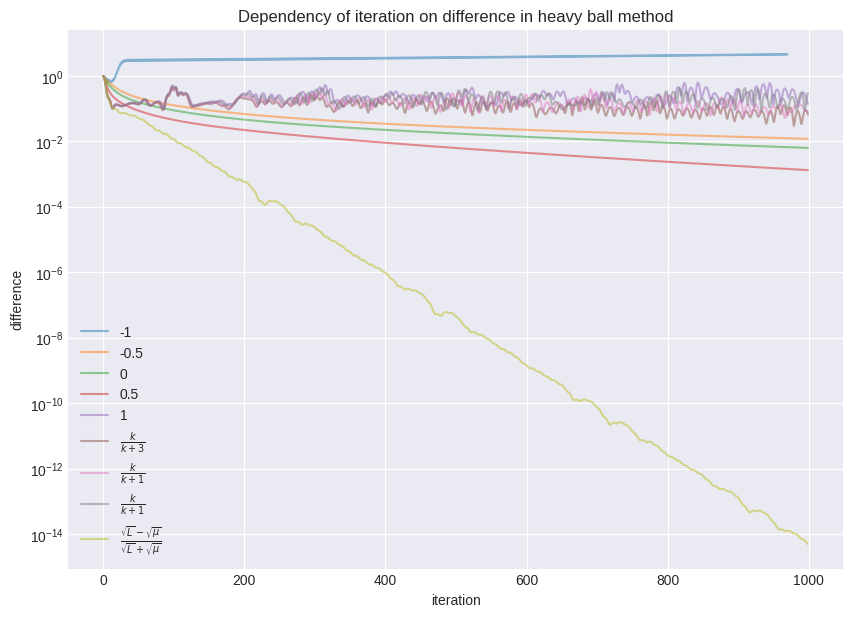

In [ ]:
M = {1:'-1', 2:'-0.5', 3:'0', 4:'0.5', 5:'1', 6:r'$\frac{k}{k + 3}$', 7:r'$\frac{k}{k + 1}$', 8:r'$\frac{k}{k + 1}$', 9:r'$\frac{\sqrt{L}-\sqrt{\mu}}{\sqrt{L}+\sqrt{\mu}}$'}  #Для корректного отображения легенды на графиках
plt.figure(figsize = (10, 7))
for i in range(len(difs)):
  plt.plot(iterations, difs[i], markersize = 5, label = M[i + 1], alpha=0.5)
plt.xlabel("iteration")
plt.ylabel("difference")
plt.yscale('log')
plt.title("Dependency of iteration on difference in heavy ball method")
plt.legend()

In [ ]:
def fast_gradient_descent_method(moment_mu, X, y, w_start, lamda, gamma):  #Функция, которая реализует метод Нестерова для всех моментов
  moments = [-1, -0.5, 0, 0.5, 1]
  all_difs = []
  for i in moments:
    tmp = fast_gradient_descent(f, nabla_f, w_start, w_start, gamma, X, y, i, K = 10**3, eps = 10**-5, moment_func = 0, lamda = lamda)
    all_difs.append(tmp[1])
  for i in range(1, 4):
    all_difs.append(fast_gradient_descent(f, nabla_f, w_start, w_start, gamma, X, y, 0, K = 10**3, eps = 10**-5, moment_func = i, lamda = lamda)[1])
  all_difs.append(fast_gradient_descent(f, nabla_f, w_start, w_start, gamma, X, y, moment_mu, K = 10**3, eps = 10**-5, moment_func = 0, lamda = lamda)[1])
  return all_difs  #Возвращаем массив массивов критериев на каждой итерации для всех моментов
iterations = [i for i in range(K)]
difs = fast_gradient_descent_method(moment_mu, X_train_tr, y_train_tr, w_start, lamda, gamma)

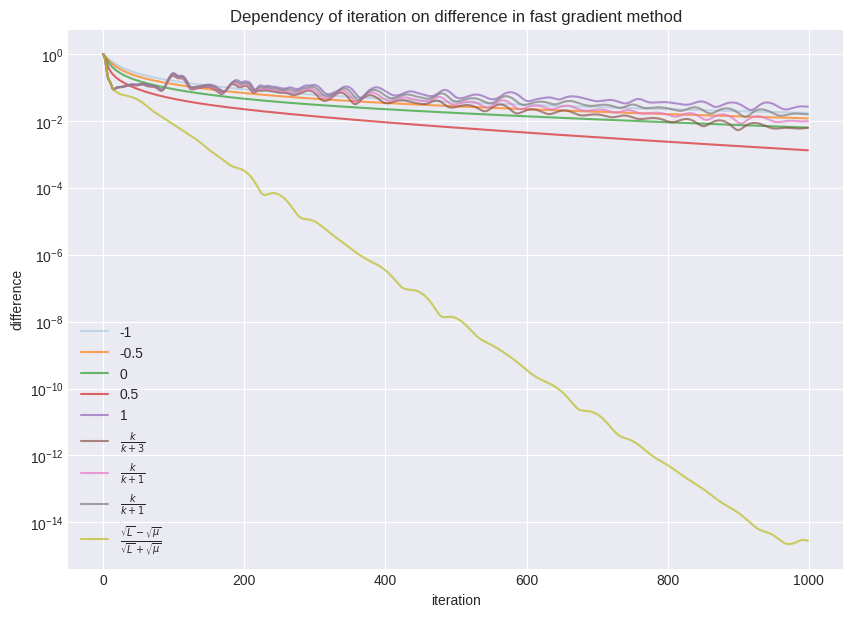

In [ ]:
plt.figure(figsize = (10, 7))
for i in range(len(difs)):
  plt.plot(iterations, difs[i], markersize = 5, label = M[i + 1], alpha=(0.2 if i == 0 else 0.7))
plt.xlabel("iteration")
plt.ylabel("difference")
plt.yscale('log')
plt.title("Dependency of iteration on difference in fast gradient method")
plt.legend()

Отсюда хорошо видно, что быстрее всего сходимость при последнем значении моментума, а именно, который нас просили рассмотрать при μ-выпуклых функциях. Также несложно увидеть по графикам, что сходимость монотонной не является, так как значение выбранного критерия сходимости всегда колеблется вверх/вниз. Теперь начертим графики для третьего пункта.

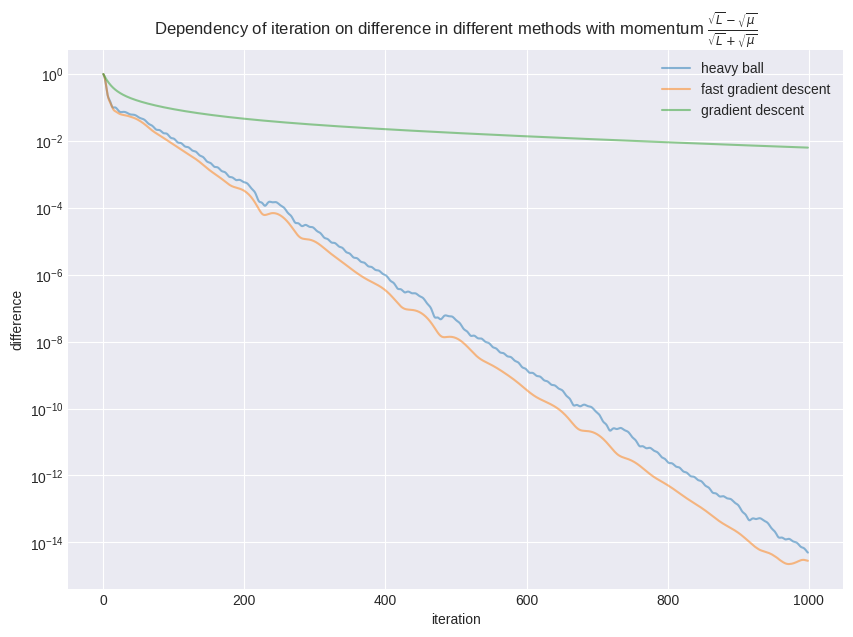

In [ ]:
def heavy_ball_method(moment_mu, X, y, w_start, lamda, gamma):  #Метод тяжелого шарика для лучшего момента
  return heavy_ball(f, nabla_f, w_start, gamma, X, y, moment_mu, K = 10**3, eps = 10**-5, moment_func = 0, lamda = lamda)[1]

def fast_gradient_descent_method(moment_mu, X, y, w_start, lamda, gamma):  #Метод Нестерова для лучшего момента
  return fast_gradient_descent(f, nabla_f, w_start, w_start, gamma, X, y, moment_mu, K = 10**3, eps = 10**-5, moment_func = 0, lamda = lamda)[1]

def gradient_descent(f, nabla_f, x_0, gamma_k, X, y,
                     K = 10**3, eps = 10**-5, lamda = 1):  #Метод градиентного спуска
    difs = []
    points = [x_0]
    for i in range(K):
      x_0_new = x_0 - gamma_k * tr.func.grad(f)(x_0, X, y, lamda)
      difs.append(criteria(points[0], x_0, X, y, lamda).detach().to().numpy())
      x_0 = x_0_new
    return difs

plt.figure(figsize = (10, 7))
plt.plot(iterations, heavy_ball_method(moment_mu, X_train_tr, y_train_tr, w_start, lamda, gamma), markersize = 5, label = 'heavy ball', alpha=0.5)
plt.plot(iterations, fast_gradient_descent_method(moment_mu, X_train_tr, y_train_tr, w_start, lamda, gamma), markersize = 5, label = 'fast gradient descent', alpha=0.5)
plt.plot(iterations, gradient_descent(f, nabla_f, w_start, gamma, X_train_tr, y_train_tr, K = 10**3, eps = 10**-5, lamda = lamda), markersize = 5, label = 'gradient descent', alpha=0.5)
plt.xlabel("iteration")
plt.ylabel("difference")
plt.yscale('log')
plt.title("Dependency of iteration on difference in different methods with momentum " + r'$\frac{\sqrt{L}-\sqrt{\mu}}{\sqrt{L}+\sqrt{\mu}}$')
plt.legend()

**Вывод**: Видим, что подтверждаются теоретические выкладки с лекции 3, а именно: метод тяжелого шарика работает в общем случае чуть хуже, чем градиентный спуск Нестерова, но при этом обычный градиентный спуск со второй лекции, как и ожидалось сходится хуже всего. (На самом деле можно было не реализовывать метод градиентного спуска, так как это и есть метод тяжелого шарика с моментумом 0, что и видно на предыдущих графиках).

__в). $\triangle$ (2 балла)__ В последние годы на практике (особенно в задачах машинного обучения) используется метод с "моментумом" в следующем виде:
\begin{align*}
    g^{-1} &= \nabla f(x^0)
    \\
    g^k &= \alpha_k g^{k-1} + \nabla f(x^k)
    \\
    x^{k+1} &= x^k - \gamma_k g^k
\end{align*}
Реализуйте метод с таким "моментумом". Попробуйте понять, как этот метод связан с методом тяжелого шарика и ускоренным градиентным методом.

In [ ]:
def criteria(x0, xk, X, y, lamda):  #Снова определяем удобный нам критерий
  return tr.norm(tr.func.grad(f)(xk, X, y, lamda)) / tr.norm(tr.func.grad(f)(x0, X, y, lamda))
def interesting_method(f, nabla_f, x_0, alpha_k, X, y, moment_k,
                     K = 10**3, eps = 10**-5, lamda = 1):  #Реализуем метод, который нам предложили в условии, перебирая разные alpha_k
    g_0 = tr.func.grad(f)(x_0, X, y, lamda)
    difs = []
    points = [x_0]
    for i in range(K):
      g_0_new = alpha_k * g_0 + tr.func.grad(f)(x_0, X, y, lamda)
      x_0_new = x_0 - moment_k * g_0_new
      difs.append(criteria(points[0], x_0, X, y, lamda).detach().to().numpy())
      g_0 = g_0_new
      x_0 = x_0_new
    return (x_0, difs)

In [ ]:
def interesting_method_best_moment(moment_mu, X, y, w_start, lamda, alpha_k):
  return interesting_method(f, nabla_f, w_start, alpha_k, X, y, moment_mu, K = 10**3, eps = 10**-5, lamda = lamda)[1]
all_difs = []
for alpha in range(5, 10):  #Перебираем alpha_k
  alpha_k = alpha / 10
  all_difs.append(interesting_method_best_moment(moment_mu, X_train_tr, y_train_tr, w_start, lamda, alpha_k))

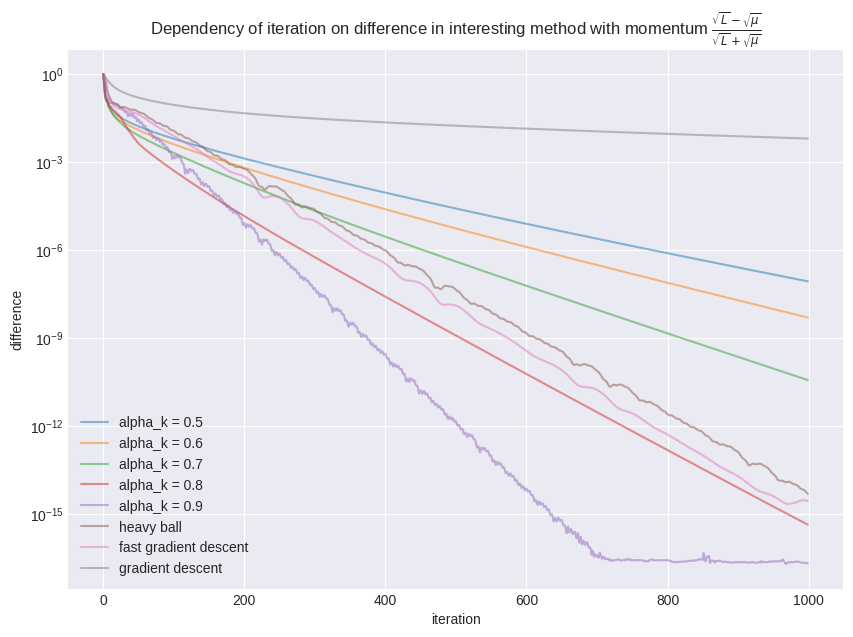

In [ ]:
plt.figure(figsize = (10, 7))
for alpha in range(5, 10):
  plt.plot(iterations, all_difs[alpha - 5], markersize = 5, label = "alpha_k = " + str(alpha / 10), alpha=0.5)
plt.plot(iterations, heavy_ball_method(moment_mu, X_train_tr, y_train_tr, w_start, lamda, gamma), markersize = 5, label = 'heavy ball', alpha=0.5)
plt.plot(iterations, fast_gradient_descent_method(moment_mu, X_train_tr, y_train_tr, w_start, lamda, gamma), markersize = 5, label = 'fast gradient descent', alpha=0.5)
plt.plot(iterations, gradient_descent(f, nabla_f, w_start, gamma, X_train_tr, y_train_tr, K = 10**3, eps = 10**-5, lamda = lamda), markersize = 5, label = 'gradient descent', alpha=0.5)
plt.xlabel("iteration")
plt.ylabel("difference")
plt.yscale('log')
plt.title("Dependency of iteration on difference in interesting method with momentum " + r'$\frac{\sqrt{L}-\sqrt{\mu}}{\sqrt{L}+\sqrt{\mu}}$')
plt.legend()

Можно сказать, что при некоторых $α_k$ этот метод явно работает лучше, чем метод тяжелого шарика и быстрого градиентного спуска, при этом между ними есть немало общего. Во всех трех методах расчет нового значения $x^{k+1}$ идет через вычитание из $x^{k}$ градиента функции на текущем шаге домноженному на некоторую константу, которая во всех методах вычисляется по разному. Но больше этот новый метод, конечно, формульно похож на метод быстрого градиентного спуска, так как тут также используются две переменные, причем вторая вычисляется с использованием предыдущей (в одном методе это $x^{k}$ и $y^{k}$, а в другом - $x^{k}$ и $g^{k}$.

__Задача 3. (всего 20 баллов)__ В этой части будем работать с методом сопряженных градиентов.

__а). (5 балла)__ Реализуйте метод Флетчера-Ривса и Полака-Рибьера. Опишите, как будете искать шага $\alpha_k$ (интересен как алгоритм, так и его инициализация). Добавьте в алгоритмы возможность делать "рестарты" (иногда брать $\beta_k = 0$) с некоторой частотой, которую можно настраивать.

Будем находить шаг $α_k$, используя метод дихотомии (бинпоиска) с прошлого домашнего задания. Стоить заметить, что хоть на лекции и говорилось про способ дихотомии и золотого сечения для поиска этого параметра, это может быть не всегда верно, так как мы помним, что он работает только для унимодальных функций. Такую функцию, как нам дали сложно проверить на унимодальность, но так как мы проверили эту функцию на сильную выпуклость и доказали, что она таковой является, то можем с уверенностью сказать, что унимодальной она также будет являться. Также добавим параметр rate, который будет обозначать, что раз в rate раз мы обнуляем коэффициент $β_k$ (то есть делаем рестарт).

In [ ]:
def criteria(x0, xk, X, y, lamda):
  return tr.norm(tr.func.grad(f)(xk, X, y, lamda)) / tr.norm(tr.func.grad(f)(x0, X, y, lamda))
def alpha(f, a, b, eps, w, X, y, p, lamda):  #Реализуем метод дихотомии для поиска шага
  c = (a + b) / 2
  while (b - a) > eps:
    d = (a + c) / 2
    if (f(w + d * p, X, y, lamda) <= f(w + c * p, X, y, lamda)):
      b = c
      c = d
    else:
      e = (b + c) / 2
      if f(w + c * p, X, y, lamda) <= f(w + e * p, X, y, lamda):
        a = d
        b = e
      else:
        a = c
        c = e
  return c


def Fletcher_rivs(f, nabla_f, x_0, p_k, X, y, K = 10**3, eps = 10**-5, lamda = 1, rate = 1):  #Реализация алгоритма Флетчера-Ривса
    '''
        f - целевая функция
        nabla_f - градиент целевой функции
        x_0 - стартовая точка
        gamma_k - функция для вычисления шага метода
        K - количество итераций (по умолчанию 1е3)
        eps - желаемая точность (по умолчанию 1е-5)
        Функция возвращает точку, в которой достигается минимум и вектор ошибок
    '''
    difs = []
    points = [x_0]
    alpha_k = 0
    betta_k = 0
    for i in range(K):
      alpha_k = alpha(f, -1000, 1000, eps, x_0, X, y, p_k, lamda)
      x_0_new = x_0 + alpha_k * p_k
      if (i % rate != 0):
        betta_k = (tr.func.grad(f)(x_0_new, X, y, lamda) @ tr.func.grad(f)(x_0_new, X, y, lamda)) / (tr.func.grad(f)(x_0, X, y, lamda) @ tr.func.grad(f)(x_0, X, y, lamda))
      else:
        betta_k = 0
      p_k = -tr.func.grad(f)(x_0_new, X, y, lamda) + betta_k * p_k
      difs.append(criteria(points[0], x_0, X, y, lamda).detach().to().numpy())
      x_0 = x_0_new
    return (x_0, difs)

def Polak_Rybier(f, nabla_f, x_0, p_k, X, y, K = 10**3, eps = 10**-5, lamda = 1, rate = 1):  #Реализация алгоритма Полака-Рибьера
    '''
        f - целевая функция
        nabla_f - градиент целевой функции
        x_0 - стартовая точка
        gamma_k - функция для вычисления шага метода
        K - количество итераций (по умолчанию 1е3)
        eps - желаемая точность (по умолчанию 1е-5)
        Функция возвращает точку, в которой достигается минимум и вектор ошибок
    '''
    difs = []
    points = [x_0]
    alpha_k = 0
    betta_k = 0
    for i in range(K):
      alpha_k = alpha(f, -1000, 1000, eps, x_0, X, y, p_k, lamda)
      x_0_new = x_0 + alpha_k * p_k
      if (i % rate != 0):
        betta_k = (tr.func.grad(f)(x_0_new, X, y, lamda) @ (tr.func.grad(f)(x_0_new, X, y, lamda) - tr.func.grad(f)(x_0, X, y, lamda))) / (tr.func.grad(f)(x_0, X, y, lamda) @ tr.func.grad(f)(x_0, X, y, lamda))
      else:
        betta_k = 0
      p_k = -tr.func.grad(f)(x_0_new, X, y, lamda) + betta_k * p_k
      difs.append(criteria(points[0], x_0, X, y, lamda).detach().to().numpy())
      x_0 = x_0_new
    return (x_0, difs)

__б). (6 баллов)__ Решите задачу оптимизации двумя реализованными методами, варьируя для каждого частоту "рестартов": $1$ (каждую итерацию $\beta_k = 0$), $10$ (каждую десятую итерацию $\beta_k = 0$), $100$, $1000$, без рестартов.

Постройте три графика: 1) значения критерия сходимости от номера итерации для метода Флетчера-Ривса с различными частотами рестартов, 2) значения критерия сходимости от номера итерации для метода Полака-Рибьера с различными частотами рестартов, 3) значения критерия сходимости от номера итерации для обоих методов с наилучшим выбором частоты рестартов. Сделайте вывод.

Так как мы выполняем всего 1000 итераций (иначе все происходит настолько долго, что можно передавать выполнение новым поколениям, а мощные компьютеры стоят дорого), то rate = 1000 и будет значить выполнение без рестартов.

In [ ]:
rates = [1, 10, 100, 1000]  #Перебираем разные частоты рестартов
all_difs = []
for rate in rates:
  all_difs.append(Fletcher_rivs(f, nabla_f, w_start, -tr.func.grad(f)(w_start, X_train_tr, y_train_tr, lamda), X_train_tr, y_train_tr, K = 10**3, eps = 10**-5, lamda = lamda, rate=rate)[1])

In [ ]:
all_difs_polak = []  #Массив для графиков разных частот перезапусков
for rate in rates:
  all_difs_polak.append(Polak_Rybier(f, nabla_f, w_start, -tr.func.grad(f)(w_start, X_train_tr, y_train_tr, lamda), X_train_tr, y_train_tr, K = 10**3, eps = 10**-5, lamda = lamda, rate=rate)[1])

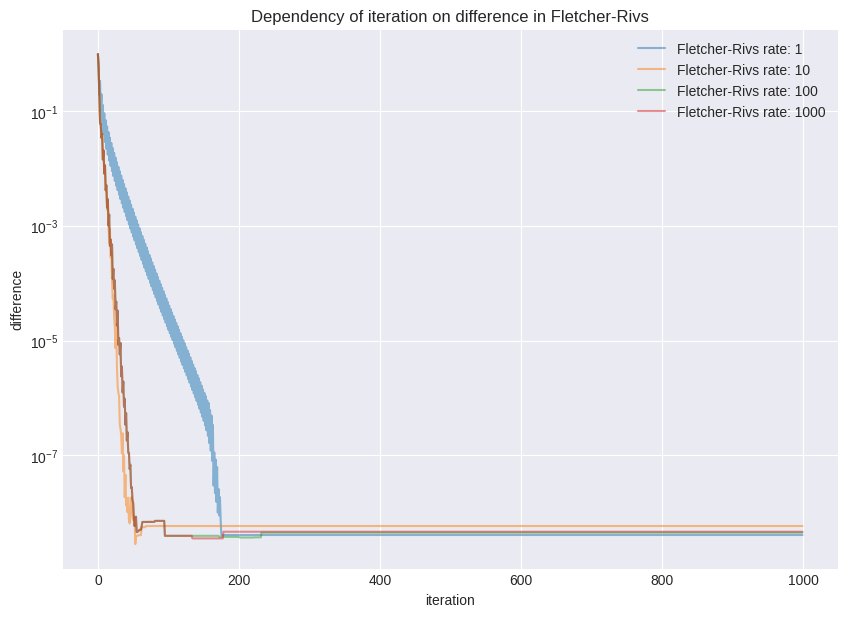

In [ ]:
plt.figure(figsize = (10, 7))
iterations = [i for i in range(1000)]
for rate in range(len(rates)):
  plt.plot(iterations, all_difs[rate], markersize = 5, label = 'Fletcher-Rivs rate: ' + str(rates[rate]), alpha=0.5)
plt.xlabel("iteration")
plt.ylabel("difference")
plt.yscale('log')
plt.title("Dependency of iteration on difference in Fletcher-Rivs")
plt.legend()

Видим, что алгоритм Флетчера-Ривса быстрее сходится c рестартом раз в 10 итераций. На лекциях объяснения лучшего рестарта не было, поэтому просто подтверждаем число 10 практикой.

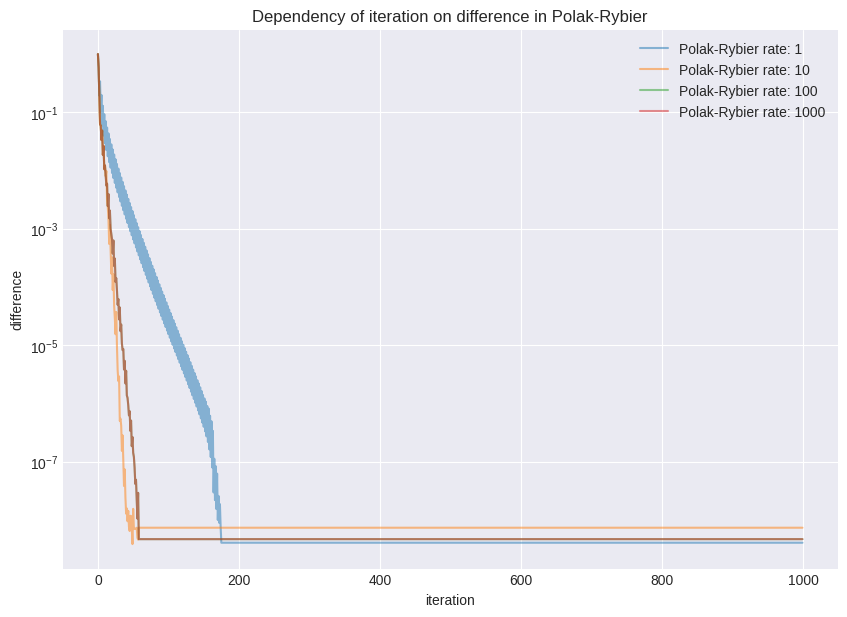

In [ ]:
plt.figure(figsize = (10, 7))
for rate in range(len(rates)):
  plt.plot(iterations, all_difs_polak[rate], markersize = 5, label = 'Polak-Rybier rate: ' + str(rates[rate]), alpha=0.5)
plt.xlabel("iteration")
plt.ylabel("difference")
plt.yscale('log')
plt.title("Dependency of iteration on difference in Polak-Rybier")
plt.legend()

Видим, что алгоритм Полака-Рибьера быстрее сходится с рестартом раз в 10 итераций. Объяснение аналогично предыдущему алгоритму. (На рисунке всего 3 графика, потому что зеленый слился с красным).

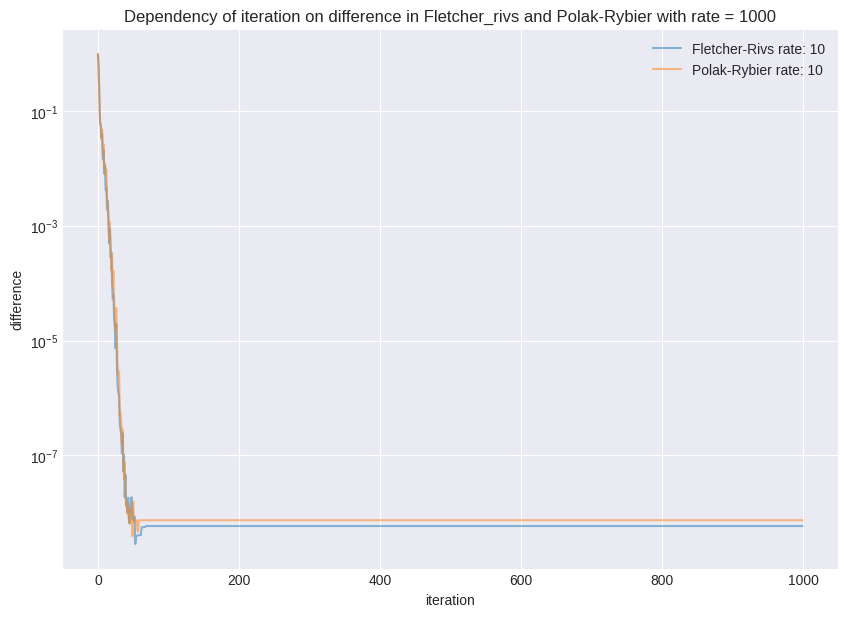

In [ ]:
plt.figure(figsize = (10, 7))
plt.plot(iterations, all_difs[1], markersize = 5, label = 'Fletcher-Rivs rate: ' + str(10), alpha=0.5)
plt.plot(iterations, all_difs_polak[1], markersize = 5, label = 'Polak-Rybier rate: ' + str(10), alpha=0.5)
plt.xlabel("iteration")
plt.ylabel("difference")
plt.yscale('log')
plt.title("Dependency of iteration on difference in Fletcher_rivs and Polak-Rybier with rate = 1000")
plt.legend()

**Вывод**: Получилось так, что оба алгоритма сходятся быстрее, если делать рестарты каждые 10 итераций (что подтверждает выводы с лекции, ведь там говорилось, что делать рестарты бывает полезно). Также видим, что оба алгоритма ведут себя достаточно гладко, и их сходимость в основном можно даже назвать монотонной. При этом на отрезке, когда график сходимости обоих алгоритмов вырождается в прямую (либо становится очень сильно сглаженным) выигрывает алгоритм Полака-Рибьера, ведь сошелся он по итогу до чуть меньшего значения и даже быстрее.

__в). $\triangle$ (9 баллов)__ В этом пункте отвлечемся от задачи регресии. Поисследуем особенности метода сопряженных градиентов для квадратичной задачи
$$\min_{x \in \mathbb{R}^d} \left[\tfrac{1}{2} x^T A x - b x \right]$$
с положительно определенной симметричной матрицей $A \in \mathbb{R}^{d \times d}$ и некоторым вектором $b \in \mathbb{R}^d$. Нам нужно научиться генерировать матрицу $A$ с возможнностью задавать ее спектр (собственные значения). В прошлом задании уже просили сделать это. Мы советуем использовать следующий подход, основанный на разложении $A = Q D Q^T$, где матрица $D$ - диагональная, образованная из собственных значений, а $Q$ - ортогональная (ее можно сгенерировать с помощью $QR$-разложения случайной матрицы).

Пусть у нас имеется квадратичная задача, у которой матрица $A \in \mathbb{R}^{d \times d}$ имеет кластеризованные собственные значения, это означает, что существует некоторое число кластеров $k \leq d$ и значения $\tilde \lambda_1 < \ldots < \tilde \lambda_k$, что для любого $\lambda_i$ собственного значения матрицы $A$ существует $j \leq k$ такой, что $\lambda_i \in [(1 - p) \tilde \lambda_j; (1 + p) \tilde \lambda_j]$, где $p < 1$.

Далее нужно будет генерировать кластеризованные собственные значения, а потом и матрицу $A$. Старайтесь при генерации спектра удостоверится, что все значения в нем разные. В качесве критерия сходимости используйте $\frac{\| x^k - x^* \|^2_A} {\| x^0 - x^* \|^2_A}$, где $k$ - номер итерации, а $\| x \|^2_A = \langle x, Ax \rangle$.

Протестируем работу метода сопряженных градиентов для различных вариантов кластеризации собственных значений:

1) Пусть $d = 100$, $k = 2$, $p = 0,05$, $\tilde \lambda_1 = 1$, в кластерах для $\tilde \lambda_1$ и $\tilde \lambda_2$ находится по 50 собственных значений. Варьируйте значение $\tilde \lambda_2$ от $10$ до $10^5$ (5 различных значений достаточно). На одном графике отобразите значения критерия сходимости от номера итерации для каждого значения $\tilde \lambda_2$. Сделайте вывод.

2) Пусть $d = 100$, $k = 2$, $p = 0,05$, $\tilde \lambda_1 = 1$, $\tilde \lambda_2 = 1000$. Варьируйте количество собственных значений в каждом из кластеров от $1$ до $99$ (5 различных значений достаточно). На одном графике отобразите значения критерия сходимости от номера итерации для каждого значения размера кластера для $\tilde \lambda_1$. Сделайте вывод.

3) Пусть $d = 100$, $p = 0,05$, $\tilde \lambda_1 = 1$, $\tilde \lambda_k = 1000$. Варьируйте количество кластеров $k$ от 2 до 100 (5 различных значений достаточно, включите 100 - соотвествует равномерному распределению собственных значений). На одном графике отобразите значения критерия сходимости от номера итерации для каждого значения  $k$. Сделайте вывод.

In [ ]:
#ваше решение (Code и Markdown)

__Задача 4. (всего 17 баллов)__ Теперь поговорим про метод Ньютона и квазиньютоновские методы.

__а). (4 балла)__ Для задачи регресии реализуйте классический метод Ньютона и запустите его. Сходится ли он? Если нет, то попробуйте перед использованием метода Ньютона сначала запускать метод градиентного спуска на несколько итераций. Варьируйте количество шагов градиентного спуска. Постройте график значения критерия сходимости от номера итерации для комбинации градиентного спуска и метода Ньютона с различным числом шагов градиентного спуска. Сделайте вывод.

In [ ]:
def criteria(x0, xk, X, y, lamda):
  return tr.norm(tr.func.grad(f)(xk, X, y, lamda)) / tr.norm(tr.func.grad(f)(x0, X, y, lamda))
def Newton(f, nabla_f, x_0, X, y, gamma_k, K = 10**3, eps = 10**-5, lamda = 1, grad_steps = 0):  #Метода Ньютона с некоторым количеством шагов
    difs = []
    points = [x_0]
    if grad_steps > 0:
      tmp = gradient_descent(f, nabla_f, x_0, gamma_k, X, y, K = grad_steps, eps = 10**-5, lamda = lamda)
      points = [x_0]
      x_0 = tmp[0]
      difs = [i for i in tmp[1]]
    for i in range(K):
      if (i == 0 or i == 1) and grad_steps == 0:
        print(tr.linalg.inv(tr.func.hessian(f)(x_0, X, y, lamda).data))
      x_0_new = x_0 - tr.linalg.inv(tr.func.hessian(f)(x_0, X, y, lamda).data) @ tr.func.grad(f)(x_0, X, y, lamda).data
      difs.append(criteria(points[0], x_0, X, y, lamda).detach().to().numpy())
      x_0 = x_0_new
    return (x_0, difs)

def gradient_descent(f, nabla_f, x_0, gamma_k, X, y,
                     K = 10**3, eps = 10**-5, lamda = 1):
    difs = []
    points = [x_0]
    for i in range(K):
      x_0_new = x_0 - gamma_k * tr.func.grad(f)(x_0, X, y, lamda)
      difs.append(criteria(points[0], x_0, X, y, lamda).detach().to().numpy())
      x_0 = x_0_new
    return [x_0, difs]

tensor([[ 1.1891e+30,  3.0782e+30, -8.6182e+30,  ...,  5.8783e+31,
         -5.7973e+30,  1.9417e+31],
        [ 1.1891e+30,  3.0782e+30, -8.6182e+30,  ...,  5.8783e+31,
         -5.7973e+30,  1.9417e+31],
        [ 1.1891e+30,  3.0782e+30, -8.6182e+30,  ...,  5.8783e+31,
         -5.7973e+30,  1.9417e+31],
        ...,
        [-8.6043e+00, -1.0161e+01, -1.1592e+01,  ...,  5.5857e+00,
          2.8440e+00, -2.0992e+01],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00,  ..., -0.0000e+00,
         -0.0000e+00, -0.0000e+00],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00,  ..., -0.0000e+00,
         -0.0000e+00, -0.0000e+00]], dtype=torch.float64)
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], dtype=torch.float64)


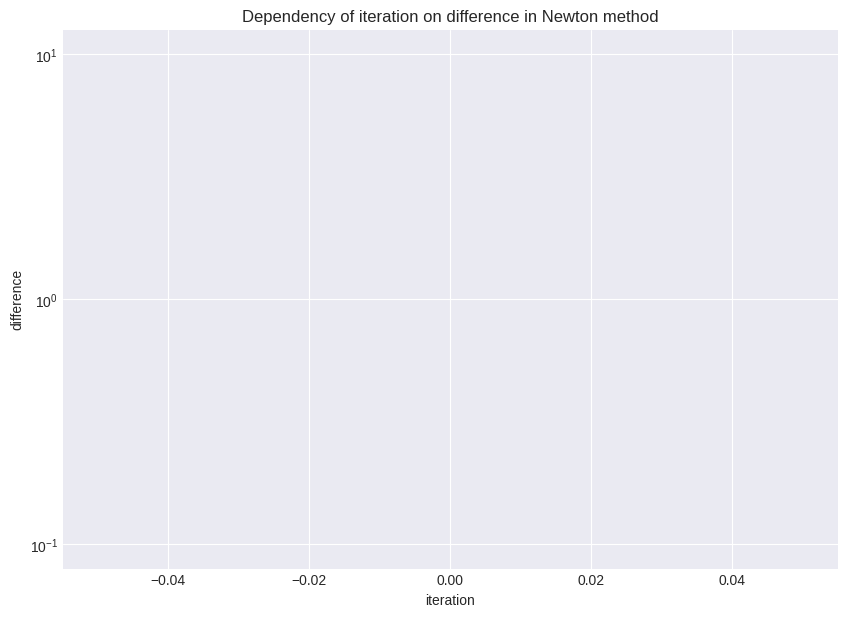

In [ ]:
K = 200
plt.figure(figsize = (10, 7))
difs = Newton(f, nabla_f, w_start, X_train_tr, y_train_tr, gamma, K = K, eps = 10**-5, lamda = lamda)[1]
iterations = [i for i in range(K)]
plt.plot(iterations, difs, markersize = 5, alpha=0.5)
plt.xlabel("iteration")
plt.ylabel("difference")
plt.yscale('log')
plt.title("Dependency of iteration on difference in Newton method")
plt.legend()

Как можно увидеть, числа уже на первой итерации алгоритма (так как метод Ньютона очень быстро сходится) в инвертированном гессиане становятся настолько большими, что на второй итерации там уже везде стоят nan, и, соответственно, нормальный график начертить у нас никак не получится. Поэтому сначала запустим несколько итераций градиентного спуска. (Из этого можно сделать вывод, что метод Ньютона без предврорительного запуска градиентного спуска не сходится ддя данной задачи).

In [ ]:
steps = [10, 50, 100, 200]  #Количество шагов градиентного спуска
K = 500  #Переопределяем количество итераций
all_difs = []
for step in steps:
  all_difs.append(Newton(f, nabla_f, w_start, X_train_tr, y_train_tr, gamma, K = K, eps = 10**-5, lamda = lamda, grad_steps=step)[1])

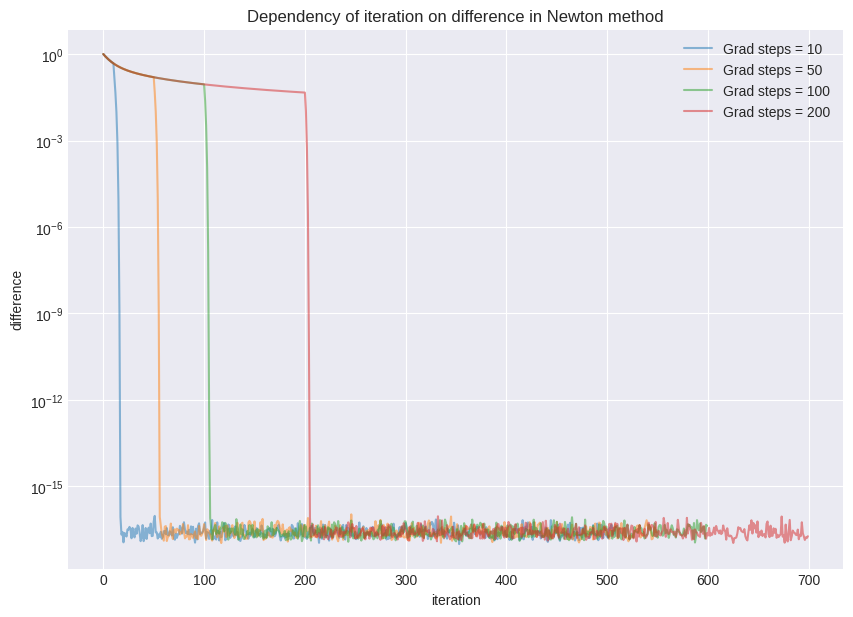

In [ ]:
plt.figure(figsize = (10, 7))
for i in range(len(all_difs)):
  iterations = [i for i in range(K + steps[i])]
  plt.plot(iterations, all_difs[i], markersize = 5, label = 'Grad steps = ' + str(steps[i]), alpha=0.5)
plt.xlabel("iteration")
plt.ylabel("difference")
plt.yscale('log')
plt.title("Dependency of iteration on difference in Newton method")
plt.legend()

Как можно увидеть по графикам, вне зависимости от того, сколько итераций градиентного спуска мы делаем до начала самого метода Ньютона, он сходится до одного и того же значения, а значит для хорошей сходимости этого метода достаточно сначала запустить одну итерацию метода градиентного спуска, которая нужна для того, чтобы мы ближе подошли к окрестности решения (устойчивого к вычислениям), чтобы не получилось так, как на графике выше.

__б). (4 балла)__ Для данной задачи реализуйте квазиньютоновский метод L-BFGS (можно посмотреть оригинальную [статью](http://users.iems.northwestern.edu/~nocedal/PDFfiles/limited-memory.pdf)). Используйте его для решения задачи регресии. Добавьте его на график из предыдущего пункта. Сделайте вывод.

In [ ]:
def BFGS(f, nabla_f, x_0, X, y, K = 10**3, eps = 10**-5, lamda = 1):  #Квазиньютоновский метод BFGS
    difs = []
    points = [x_0]
    H_k = tr.eye(len(x_0)).to(tr.float64)
    I = tr.eye(len(x_0))
    for i in range(K):
      x_0_new = x_0 - H_k @ tr.func.grad(f)(x_0, X, y, lamda).data
      ro_k = (1 / (((tr.func.grad(f)(x_0_new, X, y, lamda).data) - (tr.func.grad(f)(x_0, X, y, lamda).data)) @ (x_0_new - x_0))).to(tr.float64)
      first_multi = (I - ro_k * (x_0_new - x_0).view(-1, 1) @ ((tr.func.grad(f)(x_0_new, X, y, lamda).data) - (tr.func.grad(f)(x_0, X, y, lamda).data)).view(-1, 1).T).to(tr.float64)
      second_multi = (I - ro_k * ((tr.func.grad(f)(x_0_new, X, y, lamda).data) - (tr.func.grad(f)(x_0, X, y, lamda).data)).view(-1, 1) @ (x_0_new - x_0).view(-1, 1).T).to(tr.float64)
      H_k = first_multi @ H_k @ second_multi + ro_k * (x_0_new - x_0).view(-1, 1) @ (x_0_new - x_0).view(-1, 1).T
      difs.append(criteria(points[0], x_0, X, y, lamda).detach().to().numpy())
      x_0 = x_0_new
    return (x_0, difs)

In [ ]:
K = 500
plt.figure(figsize = (10, 7))
difs = BFGS(f, nabla_f, w_start, X_train_tr, y_train_tr, K = K, eps = 10**-5, lamda = lamda)[1]

<Figure size 1000x700 with 0 Axes>

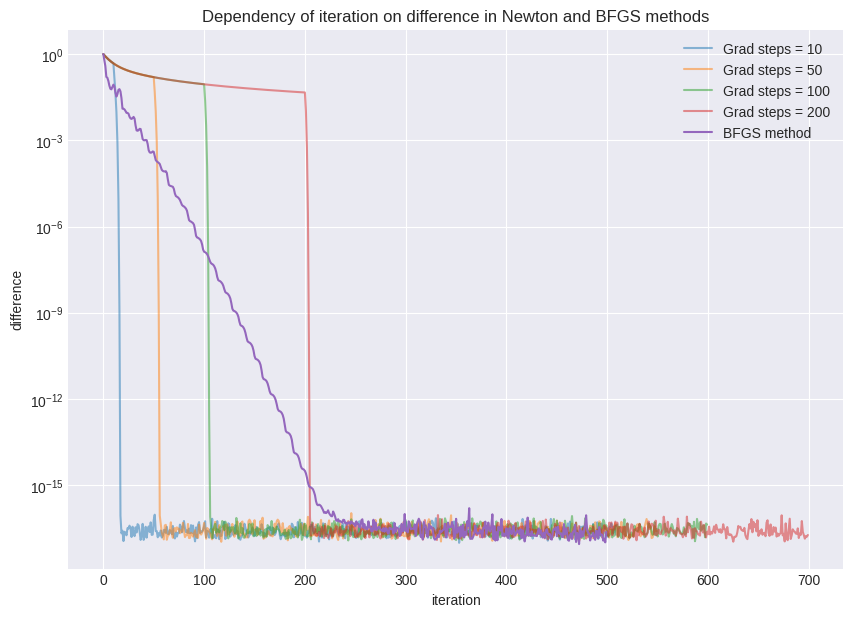

In [ ]:
plt.figure(figsize = (10, 7))
for i in range(len(all_difs)):
  iterations = [i for i in range(K + steps[i])]
  plt.plot(iterations, all_difs[i], markersize = 5, label = 'Grad steps = ' + str(steps[i]), alpha=0.5)
iterations = [i for i in range(K)]
plt.plot(iterations, difs, markersize = 5, label = 'BFGS method')
plt.xlabel("iteration")
plt.ylabel("difference")
plt.yscale('log')
plt.title("Dependency of iteration on difference in Newton and BFGS methods")
plt.legend()

Судя по этим графикам, видно, что по сравнению с методом Ньютона, который сходится в общем случае очень быстро, что на графиках отображается практически перпендикулярной оси OX линии, метод BFGS сходится более монотоннои долго , но при этом до того же значения, что и метод Ньютона.

__в). $\triangle$ (9 баллов)__ Снова отвелчемся от регресии и рассмотрим одномерную задачу минимизации:
\begin{equation}
\min_{x \in \mathbb{R}} f(x) = x \arctan x - \frac{1}{2} \log (1 + x^2).
\end{equation}
Решим эту задачу с помощью классического метода Ньютона. Нарисуйте графики сходимости метода для двух разных точек старта $x^0 = 1.3$ и $x^0 = 1.5$. Сделайте вывод.

Чтобы добиться сходимости метода Ньютона необязательно прибегать к использованию другого метода в качестве стратового. Реализуйте две модификации метода Ньютона: демпфированный (добавление шага) и кубический метод Ньютона (смотрите [статью](https://link.springer.com/article/10.1007/s10107-006-0706-8)). Решают ли эти методы проблему сходимости метода Ньютона для стартовой точки $x^0 = 1.5$? В демпфированном методе попробуйте брать шаг от $0,5$ до $1$. Постройте графики сходимости. Сделайте вывод.

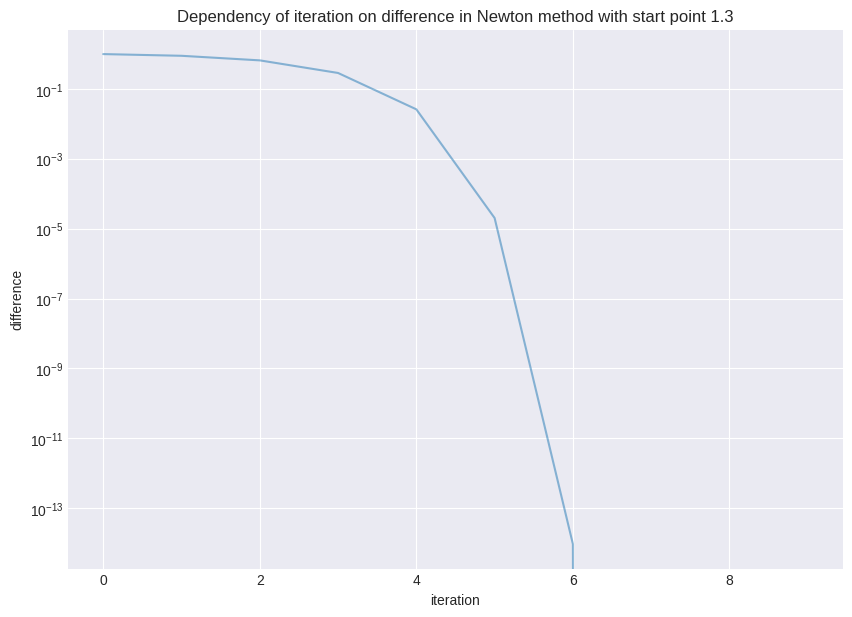

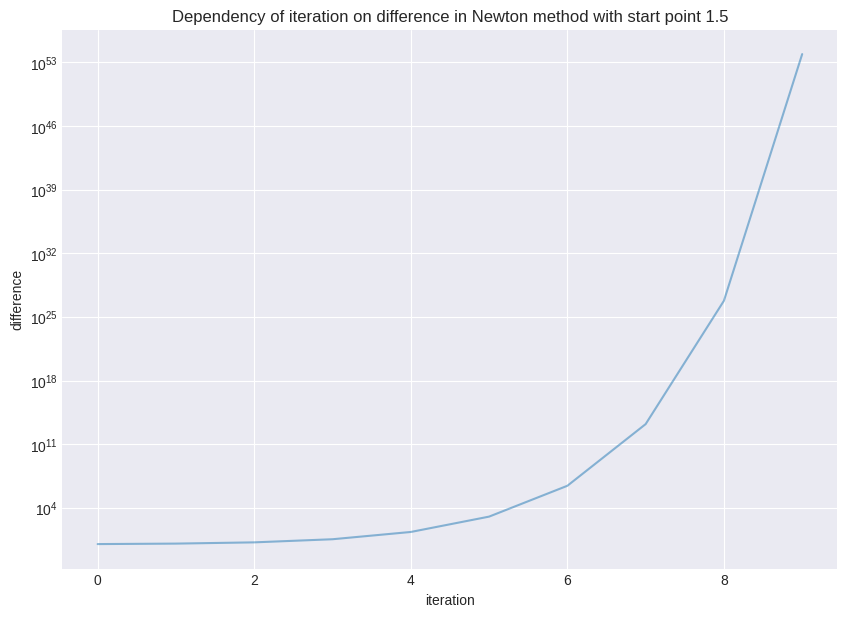

In [ ]:
def f_1(x):  #Определяем функцию из условия
  return x * tr.atan(x) - (1 / 2) * tr.log(1 + x**2)
def nabla_f_1(x):  #Определяем градиент
  return tr.func.grad(f_1)(x)
def criteria_1(x0, xk):  #Для этой задачи будем использовать другой критерий
  return abs(xk) / abs(x0)

def Newton_common(f, nabla_f, x_0, K = 10**3, eps = 10**-5):  #Обычный метод Ньютона
    difs = []
    points = [x_0]
    for i in range(K):
      x_0_new = x_0 - (1 / tr.func.hessian(f)(x_0).data) * tr.func.grad(f)(x_0).data
      difs.append(criteria_1(points[0], x_0).detach().to().numpy())
      x_0 = x_0_new
    return (x_0, difs)



w_start_1 = tr.tensor(1.3).to(tr.float64)  #Первая стартовая точка
K = 10
plt.figure(figsize = (10, 7))
iterations = [i for i in range(K)]
difs = Newton_common(f_1, nabla_f_1, w_start_1, K = K, eps = 10**-5)[1]
plt.plot(iterations, difs, markersize = 5, alpha=0.5)
plt.xlabel("iteration")
plt.ylabel("difference")
plt.title("Dependency of iteration on difference in Newton method with start point 1.3")
plt.yscale('log')
plt.legend()
K = 10
plt.figure(figsize = (10, 7))
iterations = [i for i in range(K)]
w_start_2 = tr.tensor(1.5).to(tr.float64)  #Вторая стартовая точка
difs = Newton_common(f_1, nabla_f_1, w_start_2, K = K, eps = 10**-5)[1]
plt.plot(iterations, difs, markersize = 5, alpha=0.5)
plt.xlabel("iteration")
plt.ylabel("difference")
plt.title("Dependency of iteration on difference in Newton method with start point 1.5")
plt.yscale('log')
plt.legend()

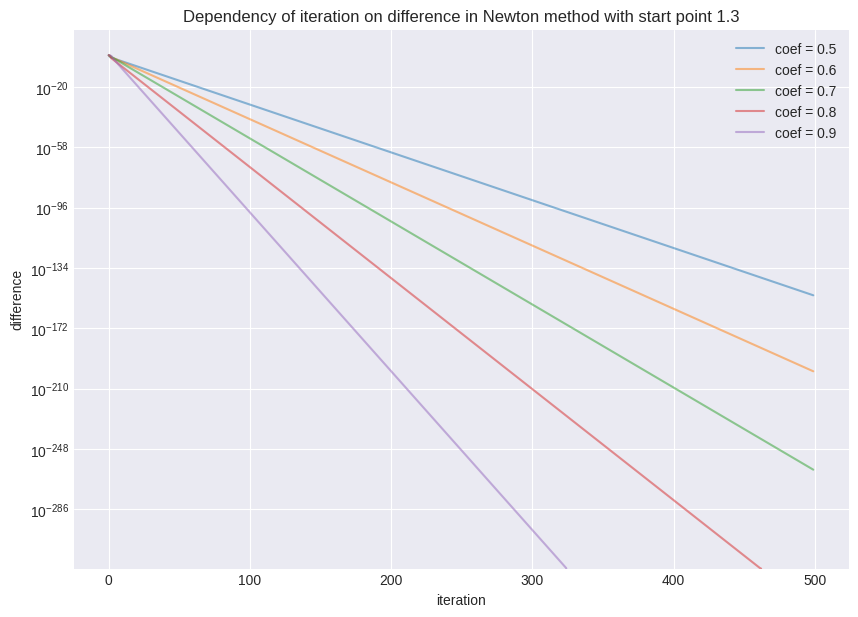

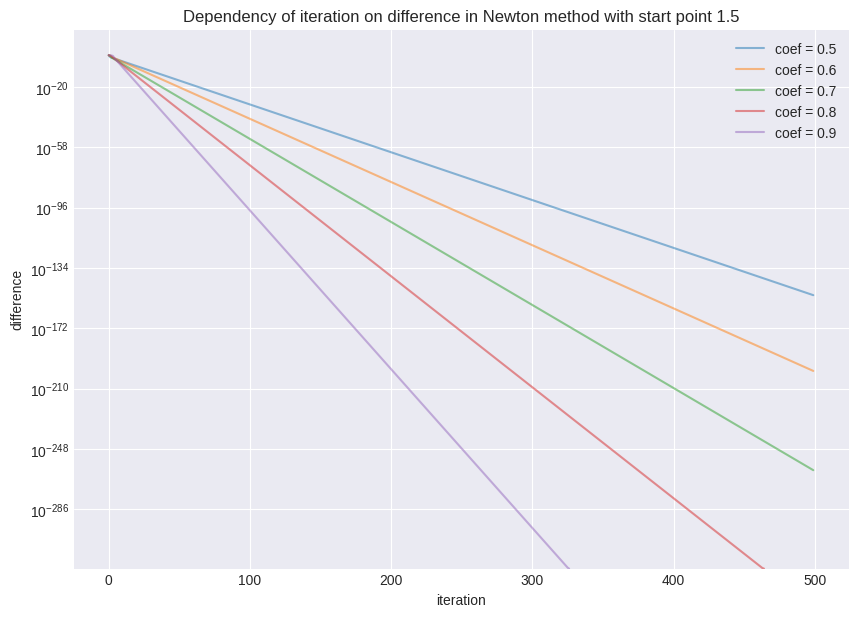

In [ ]:
def Newton_damped(f, nabla_f, x_0, gamma_k, K = 10**3, eps = 10**-5):  #Демпфированный метод Ньютона
    difs = []
    points = [x_0]
    for i in range(K):
      #print(tr.linalg.inv(tr.func.hessian(f)(x_0, X, y, lamda).data))
      x_0_new = x_0 - gamma_k * (1 / tr.func.hessian(f)(x_0).data) * tr.func.grad(f)(x_0).data
      difs.append(criteria_1(points[0], x_0).detach().to().numpy())
      x_0 = x_0_new
    return (x_0, difs)

w_start_1 = tr.tensor(1.3).to(tr.float64)  #Первая стартовая точка
K = 500
plt.figure(figsize = (10, 7))
iterations = [i for i in range(K)]
for i in range(5, 10):
  gamma = i / 10
  difs = Newton_damped(f_1, nabla_f_1, w_start_1, gamma, K = K, eps = 10**-5)[1]
  plt.plot(iterations, difs, markersize = 5, alpha=0.5, label = 'coef = ' + str(gamma))
plt.xlabel("iteration")
plt.ylabel("difference")
plt.title("Dependency of iteration on difference in Newton method with start point 1.3")
plt.yscale('log')
plt.legend()
K = 500
plt.figure(figsize = (10, 7))
iterations = [i for i in range(K)]
w_start_2 = tr.tensor(1.5).to(tr.float64)  #Вторая стартовая точка
for i in range(5, 10):
  gamma = i / 10
  difs = Newton_damped(f_1, nabla_f_1, w_start_2, gamma, K = K, eps = 10**-5)[1]
  plt.plot(iterations, difs, markersize = 5, alpha=0.5, label = 'coef = ' + str(gamma))
plt.xlabel("iteration")
plt.ylabel("difference")
plt.title("Dependency of iteration on difference in Newton method with start point 1.5")
plt.yscale('log')
plt.legend()

Такое маленькое количество итераций было выбрано, так как дальше функция становится слишком большой и график обрывается из-за nan-ов.

<ipython-input-34-b6635343739e>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  M = tr.tensor(M).to(tr.float64)


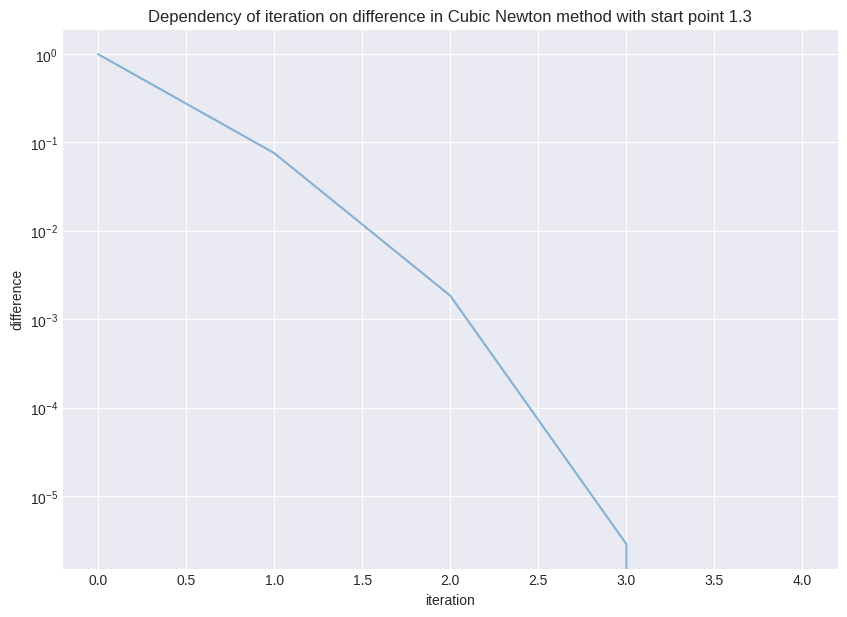

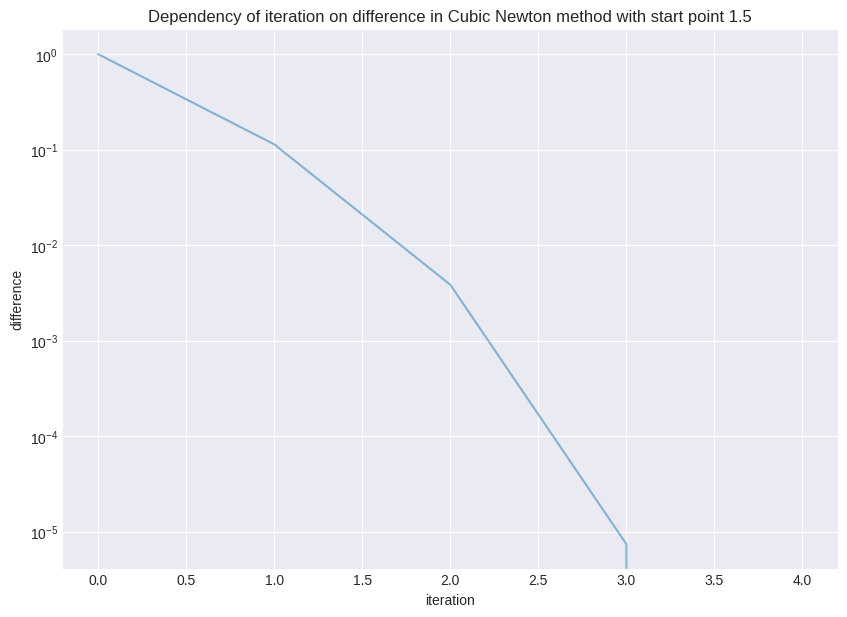

In [ ]:
def alpha(f, x_k, M, a, b, eps):  #Функция для подбора шагов в кубическом методе Ньютона
  c = (a + b) / 2
  while (b - a) > eps:
    d = (a + c) / 2
    if (f(f_1, x_k, tr.tensor(d).to(tr.float64), M) <= f(f_1, x_k, tr.tensor(c).to(tr.float64), M)):
      b = c
      c = d
    else:
      e = (b + c) / 2
      if f(f_1, x_k, tr.tensor(c).to(tr.float64), M) <= f(f_1, x_k, tr.tensor(e).to(tr.float64), M):
        a = d
        b = e
      else:
        a = c
        c = e
  return tr.tensor(c).to(tr.float64)

def new_func(f, x_k, x, M):  #Расчет x_k+1 из лекции №5
  M = tr.tensor(M).to(tr.float64)
  return f(x_k) + tr.func.grad(f)(x_k) * (x - x_k) + (1 / 2) * (x - x_k) ** 2 * tr.func.hessian(f)(x_k) + (M / 6) * tr.abs(x - x_k) ** 3

def Newton_cubic(f, nabla_f, x_0, K = 10**3, eps = 10**-5):  #Кубический метод Ньютона
    M = tr.sqrt(tr.tensor(3)) * 3 / 8
    difs = []
    points = [x_0]
    for i in range(K):
      x_0_new = alpha(new_func, x_0, M, -1000, 1000, eps)
      difs.append(criteria_1(points[0], x_0).detach().to().numpy())
      x_0 = x_0_new
    return (x_0, difs)


w_start_1 = tr.tensor(1.3).to(tr.float64)  #Первая стартовая точка
K = 5
plt.figure(figsize = (10, 7))
iterations = [i for i in range(K)]
difs = Newton_cubic(f_1, nabla_f_1, w_start_1, K = K, eps = 10**-5)[1]
plt.plot(iterations, difs, markersize = 5, alpha=0.5)
plt.xlabel("iteration")
plt.ylabel("difference")
plt.title("Dependency of iteration on difference in Cubic Newton method with start point 1.3")
plt.yscale('log')
K = 5
plt.figure(figsize = (10, 7))
iterations = [i for i in range(K)]
w_start_2 = tr.tensor(1.5).to(tr.float64)  #Вторая стартовая точка
difs = Newton_cubic(f_1, nabla_f_1, w_start_2, K = K, eps = 10**-5)[1]
plt.plot(iterations, difs, markersize = 5, alpha=0.5)
plt.xlabel("iteration")
plt.ylabel("difference")
plt.title("Dependency of iteration on difference in Cubic Newton method with start point 1.5")
plt.yscale('log')

__Задача 5. $\triangle$ (всего 5 баллов)__ Осталось объеденить результаты полученные в Задачах 1-4. Для этого вспомним, что исходная задача регрессии является задачой машинного обучения и с помощью линейной модели $g$ можно предсказывать значения меток $y$. Как использовать итоговую модель для предсказания? Ответив на вопрос, сделайте предсказания на тестовой выборке $X_{test}$. Сравните с реальными метками $y_{test}$. Количество правильно угаданных меток есть точность/accuracy модели. Сравните метод градиентного спуска, метод тяжелого шарика, ускоренный градиентный метод, метод Флетчера-Ривса, метод Полака-Рибьера, метод Ньютона, L-BFGS. Постройте два графика: значение критерия сходимости от времени работы и точность предсказания от времени работы. Сделайте вывод.

Сначала немного изменим методы. Мы хотим сохранять вектор весов на каждом шаге, чтобы потом посмотреть на динамику предсказания. Также очевидно будет брать каждый метод с лучшим моментом.

In [ ]:
def criteria(x0, xk, X, y, lamda):
  return tr.norm(tr.func.grad(f)(xk, X, y, lamda)) / tr.norm(tr.func.grad(f)(x0, X, y, lamda))
def alpha(f, a, b, eps, w, X, y, p, lamda):
  c = (a + b) / 2
  while (b - a) > eps:
    d = (a + c) / 2
    if (f(w + d * p, X, y, lamda) <= f(w + c * p, X, y, lamda)):
      b = c
      c = d
    else:
      e = (b + c) / 2
      if f(w + c * p, X, y, lamda) <= f(w + e * p, X, y, lamda):
        a = d
        b = e
      else:
        a = c
        c = e
  return c


def Fletcher_rivs(f, nabla_f, x_0, p_k, X, y, X_pred, K = 10**3, eps = 10**-5, lamda = 1, rate = 1):
    preds = []
    points = [x_0]
    alpha_k = 0
    betta_k = 0
    difs = []
    times = []
    start_time = time.time()
    for i in range(K):
      alpha_k = alpha(f, -1000, 1000, eps, x_0, X, y, p_k, lamda)
      x_0_new = x_0 + alpha_k * p_k
      if (i % rate != 0):
        betta_k = (tr.func.grad(f)(x_0_new, X, y, lamda) @ tr.func.grad(f)(x_0_new, X, y, lamda)) / (tr.func.grad(f)(x_0, X, y, lamda) @ tr.func.grad(f)(x_0, X, y, lamda))
      else:
        betta_k = 0
      p_k = -tr.func.grad(f)(x_0_new, X, y, lamda) + betta_k * p_k
      preds.append((x_0 @ X_pred.T))
      difs.append(criteria(points[0], x_0, X, y, lamda).detach().to().numpy())
      x_0 = x_0_new
      times.append(time.time() - start_time)
    return (x_0, preds, times, difs)

def Polak_Rybier(f, nabla_f, x_0, p_k, X, y, X_pred, K = 10**3, eps = 10**-5, lamda = 1, rate = 1):
    preds = []
    points = [x_0]
    alpha_k = 0
    betta_k = 0
    difs = []
    times = []
    start_time = time.time()
    for i in range(K):
      alpha_k = alpha(f, -1000, 1000, eps, x_0, X, y, p_k, lamda)
      x_0_new = x_0 + alpha_k * p_k
      if (i % rate != 0):
        betta_k = (tr.func.grad(f)(x_0_new, X, y, lamda) @ (tr.func.grad(f)(x_0_new, X, y, lamda) - tr.func.grad(f)(x_0, X, y, lamda))) / (tr.func.grad(f)(x_0, X, y, lamda) @ tr.func.grad(f)(x_0, X, y, lamda))
      else:
        betta_k = 0
      p_k = -tr.func.grad(f)(x_0_new, X, y, lamda) + betta_k * p_k
      preds.append((x_0 @ X_pred.T))
      difs.append(criteria(points[0], x_0, X, y, lamda).detach().to().numpy())
      x_0 = x_0_new
      times.append(time.time() - start_time)
    return (x_0, preds, times, difs)

def interesting_method(f, nabla_f, x_0, alpha_k, X, y, X_pred, moment_k,
                     K = 10**3, eps = 10**-5, lamda = 1):
    g_0 = tr.func.grad(f)(x_0, X, y, lamda)
    preds = []
    points = [x_0]
    difs = []
    times = []
    start_time = time.time()
    for i in range(K):
      g_0_new = alpha_k * g_0 + tr.func.grad(f)(x_0, X, y, lamda)
      x_0_new = x_0 - moment_k * g_0_new
      preds.append((x_0 @ X_pred.T))
      difs.append(criteria(points[0], x_0, X, y, lamda).detach().to().numpy())
      g_0 = g_0_new
      x_0 = x_0_new
      times.append(time.time() - start_time)
    return (x_0, preds, times, difs)

def heavy_ball(f, nabla_f, x_0, gamma_k, X, y, moment_k, X_pred,
                     K = 10**3, eps = 10**-5, lamda = 1):
    preds = []
    points = [x_0, x_0]
    difs = []
    times = []
    start_time = time.time()
    for i in range(K):
      x_0_new = x_0 - gamma_k * tr.func.grad(f)(x_0, X, y, lamda) + moment_k * (x_0 - points[-2])
      preds.append((x_0 @ X_pred.T))
      points.append(x_0_new)
      difs.append(criteria(points[0], x_0, X, y, lamda).detach().to().numpy())
      x_0 = x_0_new
      times.append(time.time() - start_time)
    return (x_0, preds, times, difs)

def fast_gradient_descent(f, nabla_f, x_0, y_0, gamma_k, X, y, moment_k, X_pred,
                     K = 10**3, eps = 10**-5, lamda = 1):
    preds = []
    points = [x_0]
    difs = []
    times = []
    start_time = time.time()
    for i in range(K):
      x_0_new = y_0 - gamma_k * tr.func.grad(f)(y_0, X, y, lamda)
      y_0_new = x_0_new + moment_k * (x_0_new - x_0)
      preds.append((x_0 @ X_pred.T))
      difs.append(criteria(points[0], x_0, X, y, lamda).detach().to().numpy())
      x_0 = x_0_new
      y_0 = y_0_new
      times.append(time.time() - start_time)
    return (x_0, preds, times, difs)

def gradient_descent(f, nabla_f, x_0, gamma_k, X, y, X_pred,
                     K = 10**3, eps = 10**-5, lamda = 1):
    preds = []
    points = [x_0]
    difs = []
    times = []
    start_time = time.time()
    for i in range(K):
      x_0_new = x_0 - gamma_k * tr.func.grad(f)(x_0, X, y, lamda)
      preds.append((x_0 @ X_pred.T))
      difs.append(criteria(points[0], x_0, X, y, lamda).detach().to().numpy())
      x_0 = x_0_new
      times.append(time.time() - start_time)
    return (x_0, preds, times, difs)

def BFGS(f, nabla_f, x_0, X, y, X_pred, K = 10**3, eps = 10**-5, lamda = 1):
    preds = []
    points = [x_0]
    H_k = tr.eye(len(x_0)).to(tr.float64)
    I = tr.eye(len(x_0))
    difs = []
    times = []
    start_time = time.time()
    for i in range(K):
      x_0_new = x_0 - H_k @ tr.func.grad(f)(x_0, X, y, lamda).data
      ro_k = (1 / (((tr.func.grad(f)(x_0_new, X, y, lamda).data) - (tr.func.grad(f)(x_0, X, y, lamda).data)) @ (x_0_new - x_0))).to(tr.float64)
      first_multi = (I - ro_k * (x_0_new - x_0).view(-1, 1) @ ((tr.func.grad(f)(x_0_new, X, y, lamda).data) - (tr.func.grad(f)(x_0, X, y, lamda).data)).view(-1, 1).T).to(tr.float64)
      second_multi = (I - ro_k * ((tr.func.grad(f)(x_0_new, X, y, lamda).data) - (tr.func.grad(f)(x_0, X, y, lamda).data)).view(-1, 1) @ (x_0_new - x_0).view(-1, 1).T).to(tr.float64)
      H_k = first_multi @ H_k @ second_multi + ro_k * (x_0_new - x_0).view(-1, 1) @ (x_0_new - x_0).view(-1, 1).T
      preds.append((x_0 @ X_pred.T))
      difs.append(criteria(points[0], x_0, X, y, lamda).detach().to().numpy())
      x_0 = x_0_new
      times.append(time.time() - start_time)
    return (x_0, preds, times, difs)

In [ ]:
L = (1000 / (3996 * len(y_train)) * np.linalg.norm(X_train, 'fro') ** 2)
lamda = L / 1000
moment_mu = (np.sqrt(L) - np.sqrt(lamda)) / (np.sqrt(L) + np.sqrt(lamda))
gamma = 1 / L
K = 10**3
w_start = tr.zeros(len(X[0]), requires_grad=True)
w_start = w_start.to(tr.float64)

In [ ]:
def make_accuracy(preds, y_real):
  accuracy = []
  for i in preds:
    counter = 0
    for j in range(len(i)):
      if tr.sign(i[j]) == tr.sign(y_real[j]):
        counter += 1
    accuracy.append(counter / len(y_real))
  return accuracy

In [ ]:
preds_gradient_descents = gradient_descent(f, nabla_f, w_start, gamma, X_train_tr, y_train_tr, X_test_tr, K = K, eps = 10**-5, lamda = lamda)
preds_gradient_descent = preds_gradient_descents[1]
times_gradient_descent = preds_gradient_descents[2]
criteria_gradient_descent = preds_gradient_descents[3]
gradient_descent_accuracies = make_accuracy(preds_gradient_descent, y_test_tr)

In [ ]:
preds_BFGSs = BFGS(f, nabla_f, w_start, X_train_tr, y_train_tr, X_test_tr, K = K, eps = 10**-5, lamda = lamda)
preds_BFGS = preds_BFGSs[1]
times_BFGS = preds_BFGSs[2]
criteria_BFGS = preds_BFGSs[3]
BFGS_accuracies = make_accuracy(preds_BFGS, y_test_tr)

In [ ]:
preds_fast_gradient_descents = fast_gradient_descent(f, nabla_f, w_start, w_start, gamma, X_train_tr, y_train_tr, moment_mu, X_test_tr, K = K, eps = 10**-5, lamda = lamda)
preds_fast_gradient_descent = preds_fast_gradient_descents[1]
times_fast_gradient_descent = preds_fast_gradient_descents[2]
criteria_fast_gradient_descent = preds_fast_gradient_descents[3]
fast_gradient_descent_accuracies = make_accuracy(preds_fast_gradient_descent, y_test_tr)

In [ ]:
preds_heavy_balls = heavy_ball(f, nabla_f, w_start, gamma, X_train_tr, y_train_tr, moment_mu, X_test_tr, K = K, eps = 10**-5, lamda = lamda)
preds_heavy_ball = preds_heavy_balls[1]
times_heavy_ball = preds_heavy_balls[2]
criteria_heavy_ball = preds_heavy_balls[3]
heavy_ball_accuracies = make_accuracy(preds_heavy_ball, y_test_tr)

In [ ]:
preds_Polak_Rybiers = Polak_Rybier(f, nabla_f, w_start, -tr.func.grad(f)(w_start, X_train_tr, y_train_tr, lamda), X_train_tr, y_train_tr, X_test_tr, K = K, eps = 10**-5, lamda = lamda, rate = 10)
preds_Polak_Rybier = preds_Polak_Rybiers[1]
times_Polak_Rybier = preds_Polak_Rybiers[2]
criteria_Polak_Rybier = preds_Polak_Rybiers[3]
Polak_Rybier_accuracies = make_accuracy(preds_Polak_Rybier, y_test_tr)

In [ ]:
preds_Fletcher_rivss = Fletcher_rivs(f, nabla_f, w_start, -tr.func.grad(f)(w_start, X_train_tr, y_train_tr, lamda), X_train_tr, y_train_tr, X_test_tr, K = K, eps = 10**-5, lamda = lamda, rate = 10)
preds_Fletcher_rivs = preds_Fletcher_rivss[1]
times_Fletcher_rivs = preds_Fletcher_rivss[2]
criteria_Fletcher_rivs = preds_Fletcher_rivss[3]
Fletcher_rivs_accuracies = make_accuracy(preds_Fletcher_rivs, y_test_tr)

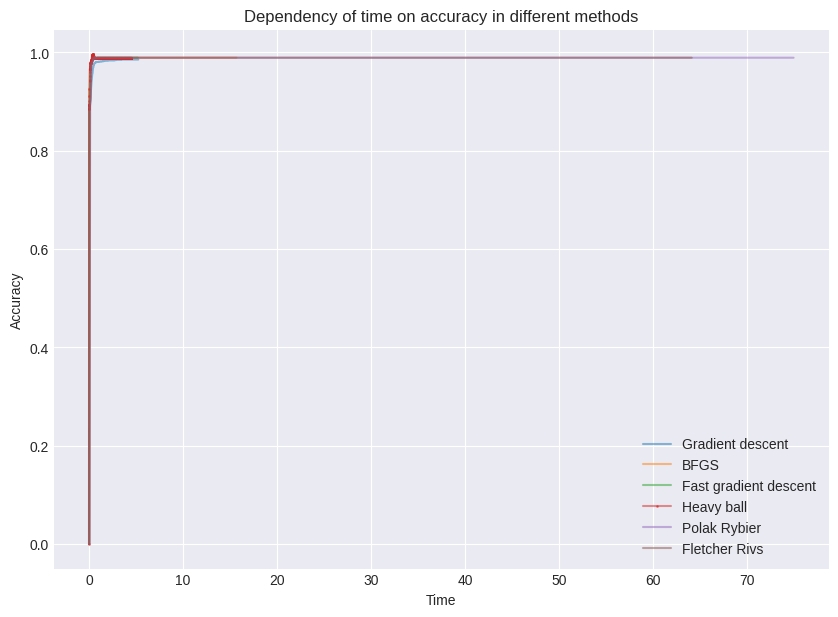

In [ ]:
plt.figure(figsize = (10, 7))
plt.plot(times_gradient_descent, gradient_descent_accuracies, markersize = 1, alpha=0.5, label='Gradient descent')
plt.plot(times_BFGS, BFGS_accuracies, markersize = 1, alpha=0.5, label='BFGS')
plt.plot(times_fast_gradient_descent, fast_gradient_descent_accuracies, markersize = 1, alpha=0.5, label='Fast gradient descent')
plt.plot(times_heavy_ball, heavy_ball_accuracies, markersize = 1, marker='o', alpha=0.5, label='Heavy ball')
plt.plot(times_Polak_Rybier, Polak_Rybier_accuracies, markersize = 1, alpha=0.5, label='Polak Rybier')
plt.plot(times_Fletcher_rivs, Fletcher_rivs_accuracies, markersize = 1, alpha=0.5, label='Fletcher Rivs')
plt.xlabel("Time")
plt.ylabel("Accuracy")
plt.title("Dependency of time on accuracy in different methods")
plt.legend()

По такому графику мы можем понять только одно: методы Флетчера-Ривса и Полака-Рибьера работают сильно дольше всех остальных, а быстрее всего работает обычный градиентный спуск. Но нас ведь интересует не только время работы, а еще и точность. Поэтому чуть-чуть обрежем графики, чтобы увидеть больше нужной информации.

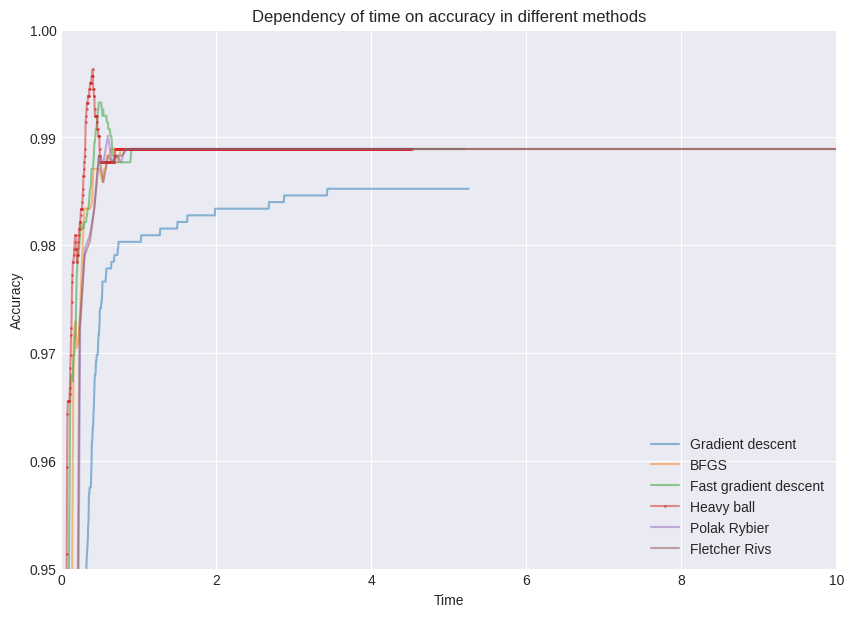

In [ ]:
plt.figure(figsize = (10, 7))
plt.plot(times_gradient_descent, gradient_descent_accuracies, markersize = 1, alpha=0.5, label='Gradient descent')
plt.plot(times_BFGS, BFGS_accuracies, markersize = 1, alpha=0.5, label='BFGS')
plt.plot(times_fast_gradient_descent, fast_gradient_descent_accuracies, markersize = 1, alpha=0.5, label='Fast gradient descent')
plt.plot(times_heavy_ball, heavy_ball_accuracies, markersize = 1, marker='o', alpha=0.5, label='Heavy ball')
plt.plot(times_Polak_Rybier, Polak_Rybier_accuracies, markersize = 1, alpha=0.5, label='Polak Rybier')
plt.plot(times_Fletcher_rivs, Fletcher_rivs_accuracies, markersize = 1, alpha=0.5, label='Fletcher Rivs')
plt.xlabel("Time")
plt.ylabel("Accuracy")
plt.title("Dependency of time on accuracy in different methods")
plt.xlim([0, 10])
plt.ylim([0.95, 1.0])
plt.legend()

Теперь мы видим, что метод градиентного спуска действительно работает быстрее всего, но его точность не впечатляет. Лучше всего, судя по графикам, работает метод тяжелого шарика, потому что он приходит к лучшей точности и при этом очень быстро. Но также можно сказать, что точность у всех методов, кроме обычного градиентного спуска примерно одинаковое, а вот время работы очень рознится.

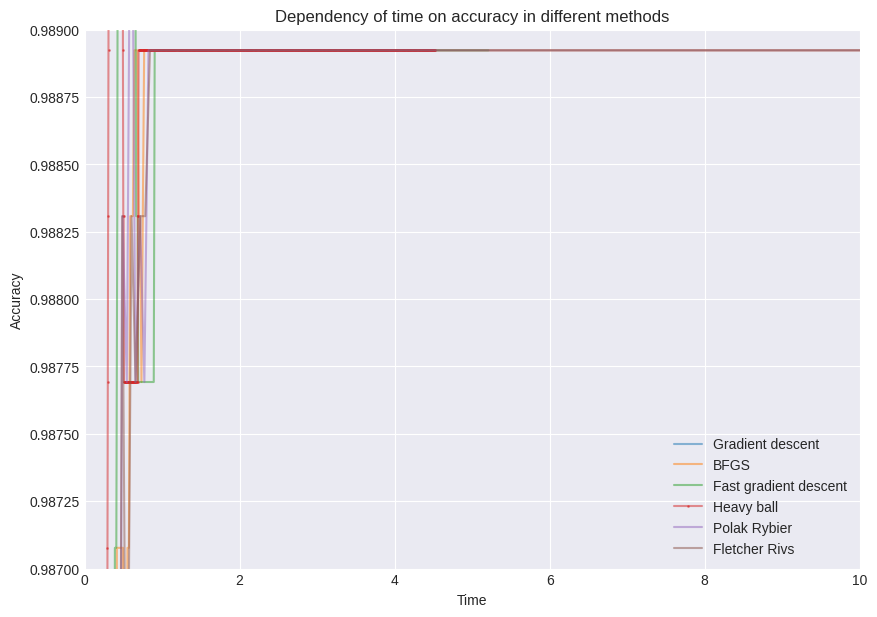

In [ ]:
plt.figure(figsize = (10, 7))
plt.plot(times_gradient_descent, gradient_descent_accuracies, markersize = 1, alpha=0.5, label='Gradient descent')
plt.plot(times_BFGS, BFGS_accuracies, markersize = 1, alpha=0.5, label='BFGS')
plt.plot(times_fast_gradient_descent, fast_gradient_descent_accuracies, markersize = 1, alpha=0.5, label='Fast gradient descent')
plt.plot(times_heavy_ball, heavy_ball_accuracies, markersize = 1, marker='o', alpha=0.5, label='Heavy ball')
plt.plot(times_Polak_Rybier, Polak_Rybier_accuracies, markersize = 1, alpha=0.5, label='Polak Rybier')
plt.plot(times_Fletcher_rivs, Fletcher_rivs_accuracies, markersize = 1, alpha=0.5, label='Fletcher Rivs')
plt.xlabel("Time")
plt.ylabel("Accuracy")
plt.title("Dependency of time on accuracy in different methods")
plt.xlim([0, 10])
plt.ylim([0.987, 0.989])
plt.legend()

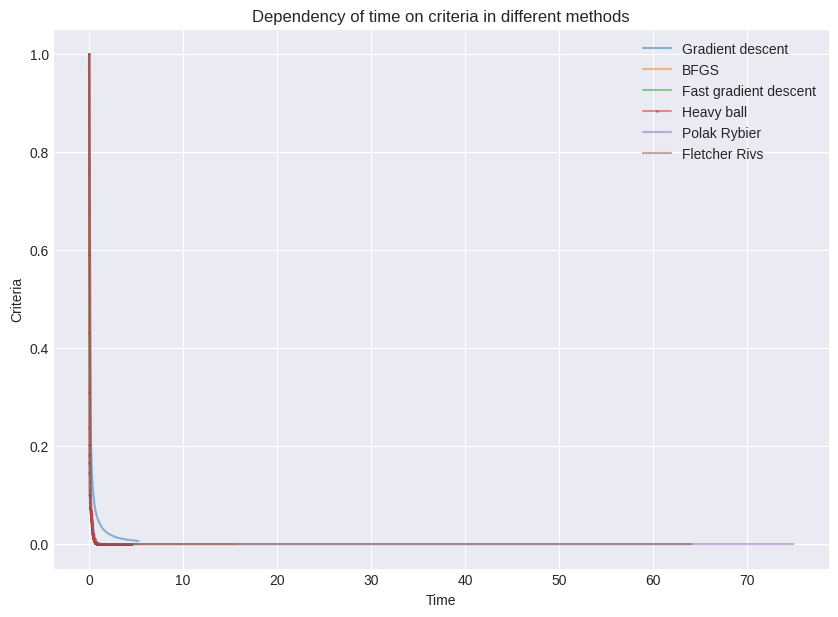

In [ ]:
plt.figure(figsize = (10, 7))
plt.plot(times_gradient_descent, criteria_gradient_descent, markersize = 1, alpha=0.5, label='Gradient descent')
plt.plot(times_BFGS, criteria_BFGS, markersize = 1, alpha=0.5, label='BFGS')
plt.plot(times_fast_gradient_descent, criteria_fast_gradient_descent, markersize = 1, alpha=0.5, label='Fast gradient descent')
plt.plot(times_heavy_ball, criteria_heavy_ball, markersize = 1, marker='o', alpha=0.5, label='Heavy ball')
plt.plot(times_Polak_Rybier, criteria_Polak_Rybier, markersize = 1, alpha=0.5, label='Polak Rybier')
plt.plot(times_Fletcher_rivs, criteria_Fletcher_rivs, markersize = 1, alpha=0.5, label='Fletcher Rivs')
plt.xlabel("Time")
plt.ylabel("Criteria")
plt.title("Dependency of time on criteria in different methods")
plt.legend()

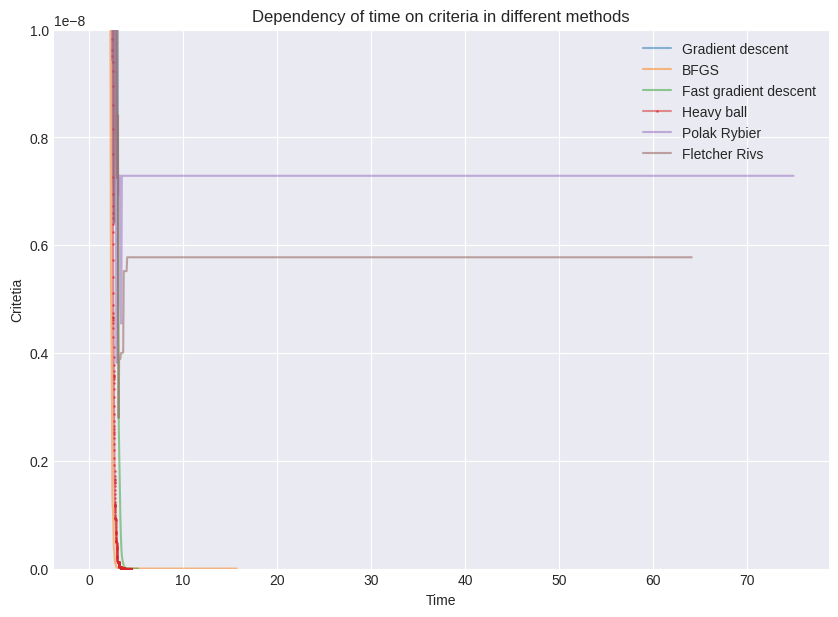

In [ ]:
plt.figure(figsize = (10, 7))
plt.plot(times_gradient_descent, criteria_gradient_descent, markersize = 1, alpha=0.5, label='Gradient descent')
plt.plot(times_BFGS, criteria_BFGS, markersize = 1, alpha=0.5, label='BFGS')
plt.plot(times_fast_gradient_descent, criteria_fast_gradient_descent, markersize = 1, alpha=0.5, label='Fast gradient descent')
plt.plot(times_heavy_ball, criteria_heavy_ball, markersize = 1, marker='o', alpha=0.5, label='Heavy ball')
plt.plot(times_Polak_Rybier, criteria_Polak_Rybier, markersize = 1, alpha=0.5, label='Polak Rybier')
plt.plot(times_Fletcher_rivs, criteria_Fletcher_rivs, markersize = 1, alpha=0.5, label='Fletcher Rivs')
plt.xlabel("Time")
plt.ylabel("Critetia")
plt.title("Dependency of time on criteria in different methods")
plt.ylim([0, 0.00000001])
plt.legend()

Теперь мы видим, что критерий сходимости примерно повторяет ситуацию с Accuracy. Метод градиентного спуска имеет не очень впечатляющий критерий сходимости, зато очень быстро работает. При этом все остальные методы имеют примерно одинаковый порядок критерия сходимости, но метод тяжелого шарика все-таки работает быстрее всего. Также стоит заметить, что методы Флетчера-Ривса и Полака-Рибьера работают очень долго и имеют худшую точность, чем методы тяжелого шарика, BFGS и метод быстрого градиентного спуска.

### Часть 2. Выпуклость

__Задача 1. (4 балла)__ Пусть $ S \subseteq \mathbb{R}^d$ и пусть $\|\cdot\|$ - норма на $\mathbb{R}^d$.

__а). (2 балла)__ Для $a \geq 0$ определим множество $S_a$ как:
$$ S_a = \{x \mid \text{dist}(x, S) \leq a \},$$
где
$$\text{dist}(x, S) = \inf_{y \in S} \| x - y \|.$$
Множество $S_a$ называется расширенным на $a$ относительно $S$. Докажите, что если $S$ выпукло, то $S_a$ также выпукло.

Воспользуемся определением выпуклости. Рассмотрим две точки $x, y ∈ S_{a}$. ∀t ∈ [0, 1]: tx + (1 - t)y ∈ $S_{a}$ - надо доказать.<br>
$dist(x, S) \leq a, dist(y, S) \leq a$ - из определения множества $S_{a}$.<br>
Пусть $z = tx + (1 - t)y$, докажем, что $dist(z, S) \leq a$.<br>
$dist(z, S) = \displaystyle{\inf_{w \in S}}||z - w||$, $\inf_{w ∈ S}||z - w|| = \inf_{w ∈ S}||tx + (1 - t)y - w|| = \inf_{w_1, w_2 ∈ S}||tx + (1 - t)y - (tw_1 + (1 - t)w_2)|| \leq t\inf_{w_1 ∈ S}||x - w|| + (1 - t)\inf_{w_2 ∈ S}||y - w|| \leq ta + (1 - t)a = a => ||z - w|| \leq a => dist(z, S) \leq a => z \in S_{a}$. ЧТД.

__б). (2 балла)__ Для $a \geq 0$ определим множество $S_{-a}$ как:
$$ S_{-a} = \{x \mid B(x, a) \subset S\}, $$
где $B(x, a)$ - открытый шар (в норме $\| \cdot \|$) с центром в $x$ и радиусом $a$. Множество $S_{-a}$ называется суженным на $a$ относительно $S$. Докажите, что если $S$ выпукло, то $S_{-a}$ также выпукло.

Пусть x, y ∈ $S_{-a}$. Надо доказать, что ∀t ∈ [0, 1]: tx + (1 - t)y ∈ $S_{-a}$.<br>
Пусть z = tx + (1 - t)y ∀t ∈ [0, 1]. Покажем, что если S - выпукло, то B(z, a) ⊂ S. Пусть B(z, a) не вложен в S. Значит ∃w ∈ B(z, a), w ∉ S. Рассмотрим отрезок между z и w. Так как w ∈ B(z, a): ||z - w|| < a. Рассмотрим u = tz + (1 - t)w ∀t ∈ [0, 1]. u ∈ B(z, a) и u ∈ [x, y]. Значит u ∈ S, так как S - выпукло. Отсюда получаем противоречие с нашим предположением, а занчит B(z, a) ⊂ S, а значит $S_{-a}$ - выпукло. ЧТД.

__Задача 2. (3 балла)__ Пусть дана функция $f: \mathbb{R}^d \to \mathbb{R}$. Выясните является ли функция выпуклой/$\mu$-сильно выпуклой, если $f(x) = \sum\limits_{i=1}^{d} x_i^4$. В случае $\mu$-сильной выпуклости нужно найти и $\mu$.

Для доказательства выпуклости воспользуемся критерием, а именно $∇^2f \geq 0$.<br>
$∇f = \displaystyle{4\sum_{i=1}^d x_i^3}$.<br>
$∇^2f = \displaystyle{12\sum_{i=1}^d x_i^2}$.<br>
Отсюда очевидно, что условие критерия выполняется, а значит f - выпукла. Но сильно выпуклой эта функция не является, так как для этого надо, чтобы $∇^2f \geq μI$, а это не всегда выполняется, так как $x_{i}$ может быть равно 0. (Эта функция не будет даже являться строго выпуклой).

__Задача 3. (всего 4 балла)__ Пусть дана функция $f: \mathbb{S}^d \to \mathbb{R}$. Здесь $\mathbb{S}$ - симметричные матрицы. Выясните является ли функция выпуклой/вогнутой, если

__а). (2 балла)__ $f(X) = \lambda_{\max}(X)$

Пусть X, Y - две симметричные матрицы, t ∈ [0, 1]. В решении этой задачи будем пользоваться следующим очевидным фактом: $λ_{max}(X)I - X \geq 0$ и аналогично для матрицы Y. Тогда сложим правые части этих неравенств, предварительно домножив их на t и на (1 - t) соответственно. Получаем: $t(λ_{max}(X)I - X) + (1 - t)(λ_{max}(Y)I - Y) \geq 0 ⇔ (tλ_{max}(X) + (1 - t)λ_{max}(Y))I \geq tX + (1 - t)Y$. Теперь применим к обеим частям неравенства функцию $f(X) = λ_{max}(X)$.<br> $λ_{max}((tλ_{max}(X) + (1 - t)λ_{max}(Y))I) \geq λ_{max}(tX + (1 - t)Y) ⇔ (tλ_{max}(X) + (1 - t)λ_{max}(Y))I \geq λ_{max}(tX + (1 - t)Y)$<br>
Это и является определением выпуклой фунции. ЧТД.

__б). (2 балла)__ $f(X) = \lambda_{\min}(X)$

Как и говорилось раньше, пользуясь прошлой задачей легко доказать то, что эта функция является вогнутой. А именно: $λ_{min}(X) = -λ_{max}(-X)$. Тогда $-λ_{min}$ является выпуклой, исходя из предыдущей задачи, а значит $λ_{min}$ - вогнутая.

__Задача 4. (3 балла)__ Выясните является ли функция $f: \mathbb{S}^d_{++} \to \mathbb{R}$ выпуклой/вогнутой, если $f(X) = \text{Tr}(X^{-1})$.

Проверим определение выпуклости для нашей функции: $∀X_{1}, X_{2} ∈ \mathbb{S}^d_{++} ∀t ∈ [0, 1]: f(tX_{1} + (1 - t)X_{2}) \leq tf(X_{1}) + (1 - t)f(X_{2})$. Пусть $Y = tX_{1} + (1 - t)X_{2}$.<br>
$f(Y) = Tr(Y^{-1})$<br>
$f(X_{1}) = Tr(X_{1}^{-1})$<br>
$f(X_{2}) = Tr(X_{2}^{-1})$<br>
$tf(X_{1}) + (1 - t)f(X_{2}) = tTr(X_{1}^{-1}) + (1  -t)Tr(X_{2}^{-1}), Tr(Y^{-1}) = Tr((tX_{1} + (1 - t)X_{2})^{-1}) \leq Tr(tX_{1}^{-1} + (1 - t)X_2^{-1})$ - для симметричных положительно определенных матриц<br>
$tf(X_{1}) + (1 - t)f(X_{2}) = tTr(X_1^{-1}) + (1 - t)Tr(X_2^{-1}) = Tr(tX_{1}^{-1} + (1 - t)X_2^{-1}) = Tr(Y^{-1})$ => получили выполнение определения выпуклой функции, а значит искомая функция является выпуклой.

__Задача 5. (3 балла)__ Пусть дано множество $X \subseteq \mathbb{R}^d$ и $x^0 \in X$. Докажите, что множество
$$K(X, x^0)=\left\{ y \in\mathbb{R}^d \mid y^T x^0 \geq y^T x \text{ for all } x \in X\right\}$$
является выпуклым конусом.

По одному из эквивалетных определений выпуклого конуса, множество K - выпуклый конус, если:
- ∀x ∈ K ∀t > 0: tx ∈ K
- ∀x, y ∈ K: x + y ∈ K

1) Замкнутость относительно умножения на неотрицательное число: ∀y ∈ $K(X, x_0)$: $y^Tx_0 \geq y^Tx$. Теперь рассмотрим t > 0 и ty. ∀x ∈ X: $(ty)^Tx_0 \geq (ty)^Tx$. Значит это условие выполнено, так как домножение обеих частей неравенства на скаляр не меняет неравенства.
2) Замкнутость отсносительно сложения: $∀y_1, y_2 ∈ K(X, x_0) ∀x ∈ X, y_1^Tx_0 \geq y_1^Tx, y_2^Tx_0 \geq y_2^Tx$. Теперь рассмотрим $t_1y_1 + t_2y_2; t_1, t_2 \geq 0$.<br>
$(t_1y_1 + t_2y_2)^Tx_0 \geq t_1y_1^Tx_0 + t_2y_2^Tx_0 \geq t_1y_1^Tx + t_2y_2^Tx$. Значит второе условие тоже проверено, а значит $K(X, x_0)$ - выпуклый конус.

__Задача 6. $\triangle$ (6 баллов)__ Воспользовавшись неравенством Йенсена для выпуклой на $\mathbb{R}_{++}$ функции $f(x) = -\ln{x}$, докажите неравенство Гёльдера: $$\sum\limits_{i=1}^d x_i y_i \le \left( \sum\limits_{i=1}^d \vert x_i\vert ^p\right)^{1/p} \left( \sum\limits_{i=1}^d \vert y_i\vert^q\right)^{1/q}$$ для $p >1, \;\; \dfrac{1}{p} + \dfrac{1}{q} = 1$. $\mathbb{R}_{++}$ - положительные действительные числа.

Для начала введем обычные обозначения из матана: $||x||_p = \displaystyle{(\sum_{i=1}^d} |x_i|^p)^{\frac{1}{p}}$.<br>
Дня начала вспомним неравенство Юнга из матана. Оно говорит о том, что: $\frac{|a|^p}{p} + \frac{|b|^q}{q} \geq |xy| \geq xy$, $\frac{1}{p} + \frac{1}{q} = 1$, причем p > 1<br>
Пусть $||x||_p \geq 0, ||y||_p \geq 0$. Воспользуемся $a = \frac{|x_i|}{||x||_p}, b = \frac{|y_i|}{||y||_p}$, получаем: $\frac{x_iy_i}{||x||_p||y||_p} \leq \frac{|x_iy_i|}{||x||_p||y||_p} \leq \frac{1}{p} \frac{|x_i|^p}{||x||^p_p} + \frac{1}{q} \frac{|x_i|^q}{||x||^q_q}$<br>
Осталось просуммировать по i полученное неравенство и получим требуемое. А именно: $\frac{1}{||x||_p||y||_q}\displaystyle{\sum_{i=1}^d x_iy_i} \leq \frac{1}{p} \frac{||x||_p^p}{||x||_p^p} + \frac{1}{q} \frac{||y||_q^q}{||y||_q^q} = 1 ⇒ \displaystyle{\sum_{i=1}^d x_iy_i \leq ||x||_p||y||_q}$. ЧТД.<br>
Если же нормы x и y изначально равны нулю, то все уже доказано, так как получим равенство.<br>
Что и требовалось доказать.

__Задача 7. $\triangle$ (6 баллов)__ Назовем множество $X \subseteq \mathbb{R}^d$ "средневыпуклым", если для любых его элементов $x$ и $y$ их середина также принадлежит $X$, т.е. $\frac{x + y}{2} \in X$. Докажите, что для замкнутых множеств "средневыпуклость" равносильна выпуклости.

Предположим противное. Пусть X - не выпуклое, но при этом замкнутое и средневыпуклое. Тогда ∃x, y ∈ X, ∃t ∈ [0, 1]: tx + (1 - t)y ∉ X. Нe умаляя общности, рассмотрим x < y и пусть z = tx + (1 - t)y. Так как z ∉ X => z ∈ $\overline{X}$, а $\overline{X}$ - открыто (это дополнение). Значит z ∈ (a, b) - открытый интервал, который не пересекается с X, a, b ∈ $\partial$X (Мы можем такой найти в силу того, что z лежит на отрезке [x, y], концы которого лежат в X. Теперь получаем, что раз множество X - средневыпукло, то $\frac{a + b}{2} ∈ X$. Но $\frac{a + b}{2} ∈ (a, b) ∉ X$ => получили противоречие с средневыпуклостью. ЧТД.

__Задача 8. $\triangle$ (6 баллов)__ Пусть $X = \{x_1, \ldots, x_{d+2}\}$ - множество из $d + 2$ точек в $\mathbb{R}^d$. Покажите, что $X$ можно разбить на два подмножества $S$ и $T = X \setminus S$ таким образом, что пересечение их выпуклых оболочек (смотри определение в Части 7 пособия) непусто.

Несложно заметить, что эта задача буквально явялется Леммой (теоремой) Радона. Докажем ее.<br>
Рассмотрим некоторое X = $\{x_1, x_2, ..., x_{d + 2}\}$ ⊂ $\mathbb{R}^d$. ∃$α_1, ..., α_{d + 2}$: $\displaystyle{\sum_{i=1}^{d+2} α_ix_i = 0, \sum_{i=1}^{d+2} α_i = 0}$, т.к. есть d + 2 неизвестных множителей, но только d + 1 уравнений, которым они должны удовлетворять (так как мы рассматриваем d-мерное пространство + еще одно уравнение, которое требует, чтобы сумма множителей была равна нулю). Теперь рассмотрим I ⊂ X - множество точек с положительными множителями, а J = X \ I - множество точек с отрицательными или нулевыми множителями. Докажем, что I и J и предсатвляют собой искомое разбиение.<br>
На самом деле выпуклые оболочки I и J пересекаются, потому что оба содержат точку $p = \displaystyle{\sum_{x_i ∈ I} \frac{a_i}{A}x_i = \sum_{x_j ∈ J} \frac{-a_j}{A}x_j}$, где $A = \displaystyle{\sum_{x_i ∈ I}a_i = -\sum_{x_j ∈ J}a_j}$. Это выполняется, так как в линейная комбинация всех должна быть равна 0, а значит соответствующие суммы действительно равны. Этот факт завершает доказательство. ЧТД.